In [2]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pathlib
import pandas as pd
from pprint import pprint
import math
import pyarrow.dataset as ds
from scipy.stats import linregress
from lmfit import Model 

In [1]:
beam = "B1" # or "B2"
ip   = "1" 
bsrt_loc = '5R4' if beam.upper() == 'B1' else '5L4'
RAWDATA = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/rawdata')
FILLINFO       = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/fills-info")
fbmodes        = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")

NameError: name 'Path' is not defined

In [ ]:
#load variabled
int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
emitH_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
emitV_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"
loss_b1 = 'UCAP.LHC.LUMI.LOSSES:EffectiveCrossSectionPerBunch:effectiveCrossSectionB1'
loss_b2 = "UCAP.LHC.LUMI.LOSSES:EffectiveCrossSectionPerBunch:effectiveCrossSectionB2"
lev_pv = "LHC.LUMISERVER:LumiLevelingIP1:Enable"
beta_pv     = "HX:BETASTAR_IP1"
xing_pv     = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"
fills = np.array([10665,10666,10671,10673,10675,10676,10685,10689,10690,10701,10717,10721,10732,10709]) #fills with same filling scheme
orbit_len = 3564

# Build data frame for ip collisions

In [ ]:
# Build Families for ONE fill
def build_families_for_fill(
    fillno: int,
    beam: str,
    ip: str,
    RAWDATA: Path,
    long_gap_set=(32, 63),
    small_gap=8,
    F4_offset_after_long=6,    # 7th bunch (bid_first + 6)
    F6_offset_before_small=26, # 27th bunch (bid_first + 26)
    enforce_filled=True,
    intensity_threshold=None,
) -> dict:
    fpat = LHCFillingPattern(fillno, RAWDATA)
    # beam-specific train table
    if beam.upper() == "B1":
        trains = fpat.bunchtrainsDF_b1.copy()
        filled_slots = fpat.bunches_b1
    else:
        trains = fpat.bunchtrainsDF_b2.copy()
        filled_slots = fpat.bunches_b2

    trains = (
        trains.loc[trains["id"] != 0]
              .sort_values("bid_first")
              .reset_index(drop=True)
    )
    # optional 
    if intensity_threshold is not None:
        int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
        ser_int = load_series(int_var, RAWDATA, fillno=fillno)
        if ser_int.empty:
            arr_intensity = np.zeros(orbit_len, dtype=float)
        else:
            last_vals = np.asarray(ser_int.iloc[-1])
            if last_vals.shape[0] != orbit_len:
                tmp = np.zeros(orbit_len, dtype=float)
                n = min(orbit_len, last_vals.shape[0])
                tmp[:n] = last_vals[:n]
                last_vals = tmp
            arr_intensity = last_vals
    else:
        arr_intensity = None

    filled_mask = np.zeros(orbit_len, dtype=bool)
    filled_mask[filled_slots] = True

    def _filter(arr: np.ndarray) -> np.ndarray:
        if arr.size == 0:
            return arr
        arr = arr.astype(int)
        if enforce_filled:
            arr = arr[filled_mask[arr]]
        if arr_intensity is not None and intensity_threshold is not None:
            arr = arr[arr_intensity[arr] >= intensity_threshold]
        return arr

    # Family_1: first bunch of trains whose *preceding* gap is long (32 or 63)
    mask_long = trains["gap"].isin(long_gap_set)
    Family_1 = trains.loc[mask_long, "bid_first"].to_numpy(int)

    # Family_2: last bunch of a train that is followed by a long (≥31) gap
    next_start = trains["bid_first"].shift(-1).fillna(orbit_len).astype(int)
    trains["gap_after"] = next_start - trains["bid_last"] - 1
    mask_big_gap = trains["gap_after"] >= 31
    Family_2 = trains.loc[mask_big_gap, "bid_last"].to_numpy(int)

    # Family_3: first slot of max LR encounter per train
    lr = fpat.lrencounters[beam][f"ip{ip}"]  # length-3564 array
    peak_slots = []
    for _, row in trains.iterrows():
        bids = np.asarray(row["bids"], dtype=int)
        lr_train = lr[bids]
        max_val = lr_train.max()
        first_idx = np.where(lr_train == max_val)[0][0]
        peak_slots.append(bids[first_idx])
    Family_3 = np.asarray(peak_slots, dtype=int)

    # Family_4: 7th bunch in long-gap trains (bid_first + 6)
    Family_4 = (trains.loc[mask_long, "bid_first"] + F4_offset_after_long).to_numpy(int)

    # Family_5: 15th bunch in trains whose *preceding* gap == small_gap
    mask_gap_small_15 = (trains["gap"] == small_gap) & (trains["nbunches"] >= 15)
    cand_F5 = (trains.loc[mask_gap_small_15, "bid_first"] + 14).to_numpy(int)
    # clip to each selected train's end (safety)
    last_F5 = trains.loc[mask_gap_small_15, "bid_last"].to_numpy(int)
    Family_5 = cand_F5[cand_F5 <= last_F5]

    # Family_6: 27th bunch IN THE TRAIN *BEFORE* a gap==8 train
    rows_gap8 = trains["gap"] == small_gap
    train_before_gap8 = trains.shift(1).loc[rows_gap8].dropna()
    mask_nbunch27 = train_before_gap8["nbunches"] >= (F6_offset_before_small + 1)
    Family_6 = (train_before_gap8.loc[mask_nbunch27, "bid_first"] + F6_offset_before_small).to_numpy(int)

    # Family_7: first bunch AFTER an 8-slot gap (the gap8 train itself)
    Family_7 = trains.loc[rows_gap8, "bid_first"].to_numpy(int)

    # Family_8: last bunch BEFORE each gap8 (the last bunch of the previous train)
    train_before_gap8_full = trains.shift(1).loc[rows_gap8].dropna()
    Family_8 = train_before_gap8_full["bid_last"].astype(int).to_numpy()

    fam_dict = {
        "Family_1": _filter(Family_1),
        "Family_2": _filter(Family_2),
        "Family_3": _filter(Family_3),
        "Family_4": _filter(Family_4),
        "Family_5": _filter(Family_5),
        "Family_6": _filter(Family_6),
        "Family_7": _filter(Family_7),
        "Family_8": _filter(Family_8),
    }

    # report
    #print(f"\n=== Families for fill {fillno} ({beam}, {ip}) ===")
    ##for k, v in fam_dict.items():
        #print(f"{k}: n={len(v)}  slots={v}")

    return fam_dict

# Minimal load_series helper
def load_series(var: str, RAWDATA: Path, fillno: int) -> pd.Series:
    root = RAWDATA / f"HX:FILLN={fillno}"
    parts = []
    for pq in root.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[var])
        except Exception:
            continue
        idx = pd.to_datetime(df.index, utc=True, errors="coerce")
        ser = pd.Series(df[var].to_numpy(), index=idx, name=var)
        parts.append(ser.dropna())
    if not parts:
        return pd.Series(dtype=float, name=var)
    return pd.concat(parts).sort_index()


In [5]:
fams_by_fill = {}
records = []   # for long DataFrame

for fillno in fills:
    fams = build_families_for_fill(
        fillno=fillno,
        beam=beam,
        ip=ip,
        RAWDATA=RAWDATA,
        # (optionally pass thresholds/offset overrides if needed)
    )
    fams_by_fill[fillno] = fams
# ------------------------------------------------------------------
# group back by fill -> dict, then assemble as columns
wide_rows = []
for fillno, fams in fams_by_fill.items():
    row = {"fill": fillno}
    for fam_name, slots in fams.items():
        row[fam_name] = np.array(slots, dtype=int)  # ragged arrays stored as objects
    wide_rows.append(row)

df_families_wide = pd.DataFrame(wide_rows)
print("df_families_wide shape:", df_families_wide.shape)
display(df_families_wide)

df_families_wide shape: (14, 9)


,fill,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8
0,10665,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
1,10666,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
2,10671,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
3,10673,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
4,10675,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
5,10676,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
6,10685,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
7,10689,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
8,10690,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 16...","[71, 114, 157, 224, 267, 310, 353, 420, 463, 5...","[61, 214, 410, 606, 802, 955, 1108, 1304, 1500...","[112, 155, 265, 308, 351, 461, 504, 547, 657, ...","[81, 124, 234, 277, 320, 430, 473, 516, 626, 6...","[98, 141, 251, 294, 337, 447, 490, 533, 643, 6...","[90, 133, 243, 286, 329, 439, 482, 525, 635, 6..."
9,10701,"[55, 208, 404, 600, 796, 949, 1102, 1298, 1494...","[176, 372, 568, 764, 917, 1070, 1266, 1462, 1

In [ ]:
def _ip_collision_sets_for_fill(fillno: int, beam: str, RAWDATA: Path):
    fpat = LHCFillingPattern(fillno, RAWDATA)

    if beam.upper() == "B1":
        ip15 = np.asarray(fpat.collbid_ip15["B1"], dtype=int)
        ip2  = np.asarray(fpat.collbid_ip2 ["B1"], dtype=int)
        ip8  = np.asarray(fpat.collbid_ip8 ["B1"], dtype=int)
    else:
        ip15 = np.asarray(fpat.collbid_ip15["B2"], dtype=int)
        ip2  = np.asarray(fpat.collbid_ip2 ["B2"], dtype=int)
        ip8  = np.asarray(fpat.collbid_ip8 ["B2"], dtype=int)

    return {
        "15": set(ip15),
        "2":  set(ip2),
        "8":  set(ip8),
    }

# Classify a numpy array of slots into exclusive IP groups
def _classify_slots_by_ip(slots: np.ndarray, set15, set2, set8):
    """
    Given 1D int array `slots` and three sets (IP15, IP2, IP8),
    return dict {ip_group_label: np.ndarray([...])}.
    """
    slots = np.asarray(slots, dtype=int)

    # for each slot, boolean membership
    in15 = np.array([s in set15 for s in slots], dtype=bool)
    in2  = np.array([s in set2  for s in slots], dtype=bool)
    in8  = np.array([s in set8  for s in slots], dtype=bool)

    # masks
    m15_only   =  in15 & ~in2 & ~in8
    m2_only    = ~in15 &  in2 & ~in8
    m8_only    = ~in15 & ~in2 &  in8

    m15_2      =  in15 &  in2 & ~in8
    m15_8      =  in15 & ~in2 &  in8
    m2_8       = ~in15 &  in2 &  in8

    m15_2_8    =  in15 &  in2 &  in8

    # any that did not match any of above (should be none or "non colliding")
    mnone      = ~(m15_only | m2_only | m8_only | m15_2 | m15_8 | m2_8 | m15_2_8)

    return {
        "15_only":   slots[m15_only],
        "2_only":    slots[m2_only],
        "8_only":    slots[m8_only],
        "15_2":      slots[m15_2],
        "15_8":      slots[m15_8],
        "2_8":       slots[m2_8],
        "15_2_8":    slots[m15_2_8],
        "none":      slots[mnone],
    }

# Main: explode fams_by_fill into IP-partitioned long & summary DFs
def build_family_ip_partitions(
    fams_by_fill: dict,
    RAWDATA: Path,
    beam: str,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    long_records = []
    summary_records = []

    for fillno, fams in fams_by_fill.items():
        # Get IP sets for this fill
        ip_sets = _ip_collision_sets_for_fill(fillno, beam, RAWDATA)
        set15, set2, set8 = ip_sets["15"], ip_sets["2"], ip_sets["8"]

        for fam_name, slots in fams.items():
            slots = np.asarray(slots, dtype=int)

            part_dict = _classify_slots_by_ip(slots, set15, set2, set8)

            # long rows
            for ip_group, arr in part_dict.items():
                for s in arr:
                    long_records.append({
                        "fill": fillno,
                        "family": fam_name,
                        "ip_group": ip_group,
                        "slot": int(s),
                    })

            # summary counts
            rec = {
                "fill": fillno,
                "family": fam_name,
            }
            for ip_group, arr in part_dict.items():
                rec[ip_group] = int(len(arr))
            summary_records.append(rec)

    # assemble long
    if long_records:
        df_families_ip_long = (
            pd.DataFrame.from_records(long_records)
              .sort_values(["fill", "family", "ip_group", "slot"])
              .reset_index(drop=True)
        )
    else:
        df_families_ip_long = pd.DataFrame(columns=["fill", "family", "ip_group", "slot"])

    # assemble summary
    if summary_records:
        df_families_ip_summary = (
            pd.DataFrame.from_records(summary_records)
              .sort_values(["fill", "family"])
              .reset_index(drop=True)
        )
    else:
        df_families_ip_summary = pd.DataFrame(columns=["fill", "family"])

    return df_families_ip_long, df_families_ip_summary

df_families_ip_long, df_families_ip_summary = build_family_ip_partitions(
    fams_by_fill=fams_by_fill,
    RAWDATA=RAWDATA,
    beam=beam,          # same beam as used when building families
)

print("df_families_ip_long shape:", df_families_ip_long.shape)
display(df_families_ip_long.head())

print("df_families_ip_summary shape:", df_families_ip_summary.shape)
display(df_families_ip_summary.head(9))

df_families_ip_long shape: (4494, 4)


,fill,family,ip_group,slot
0,10665,Family_1,15_2_8,1843
1,10665,Family_1,15_2_8,1996
2,10665,Family_1,15_2_8,2192
3,10665,Family_1,15_2_8,2388
4,10665,Family_1,15_8,55


df_families_ip_summary shape: (112, 10)


,fill,family,15_only,2_only,8_only,15_2,15_8,2_8,15_2_8,none
0,10665,Family_1,5,0,0,0,10,0,4,0
1,10665,Family_2,0,0,0,1,6,0,12,0
2,10665,Family_3,0,0,0,2,3,0,63,0
3,10665,Family_4,0,0,0,5,1,0,13,0
4,10665,Family_5,0,0,0,1,2,0,46,0
5,10665,Family_6,0,0,0,2,1,0,46,0
6,10665,Family_7,2,0,0,0,36,0,11,0
7,10665,Family_8,0,0,0,2,1,0,46,0
8,10666,Family_1,5,0,0,0,10,0,4,0


# Injection

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


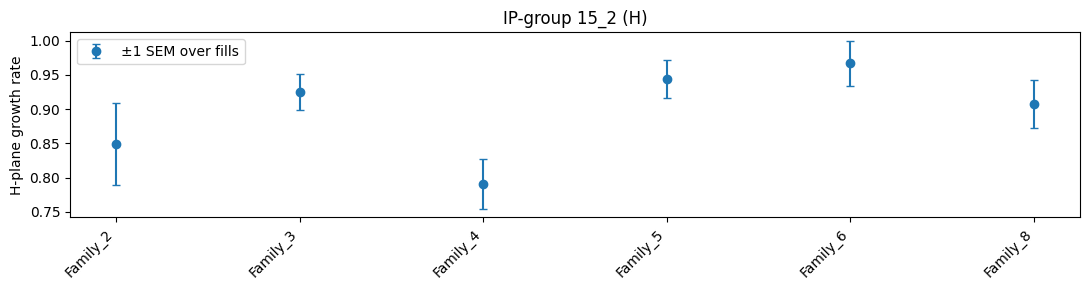

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


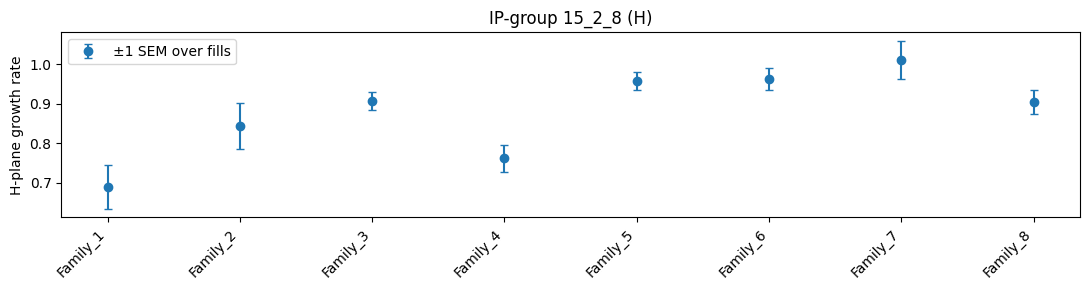

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


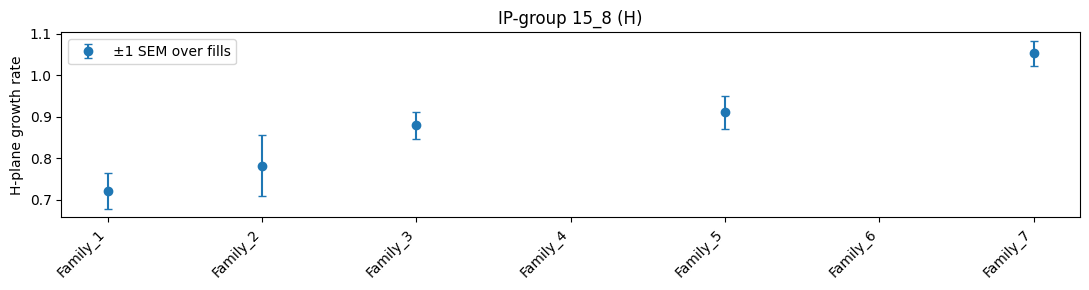

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


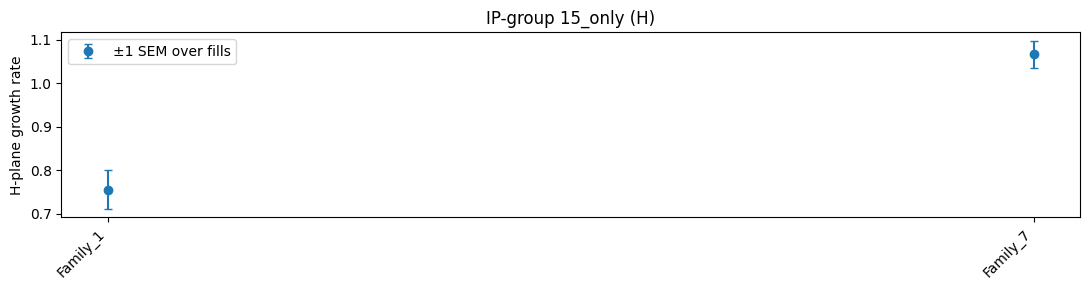

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


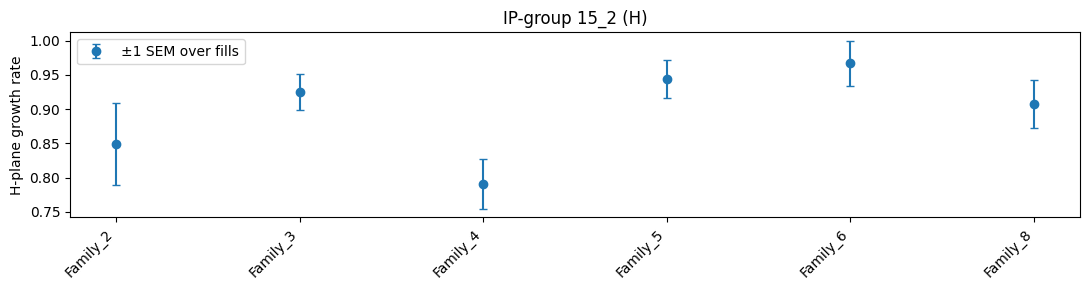

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


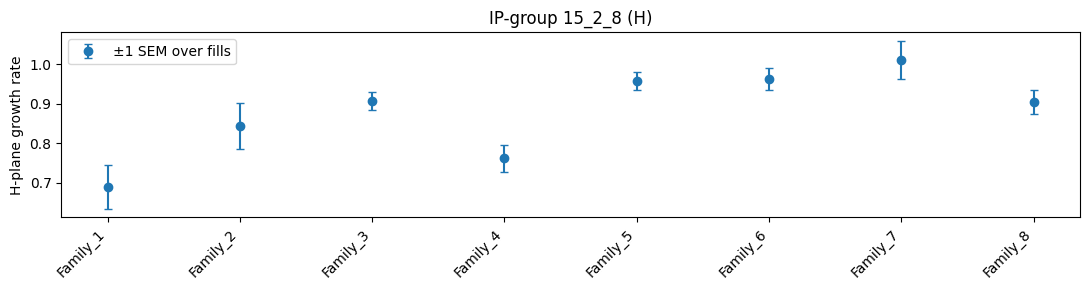

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


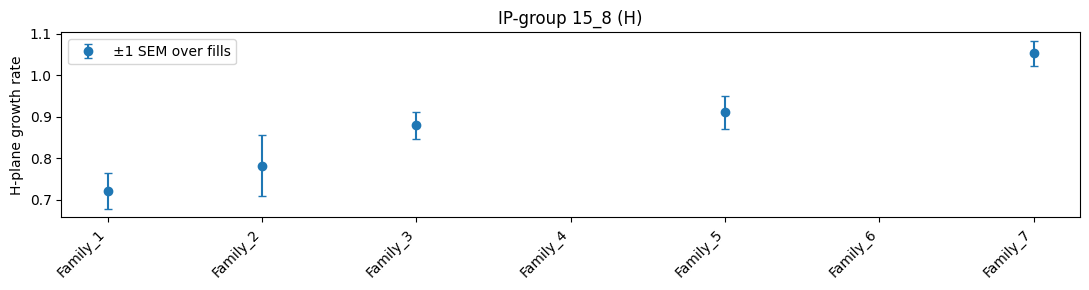

/tmp/kpervain/ipykernel_576973/782164509.py:378: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fams, rotation=45, ha="right")


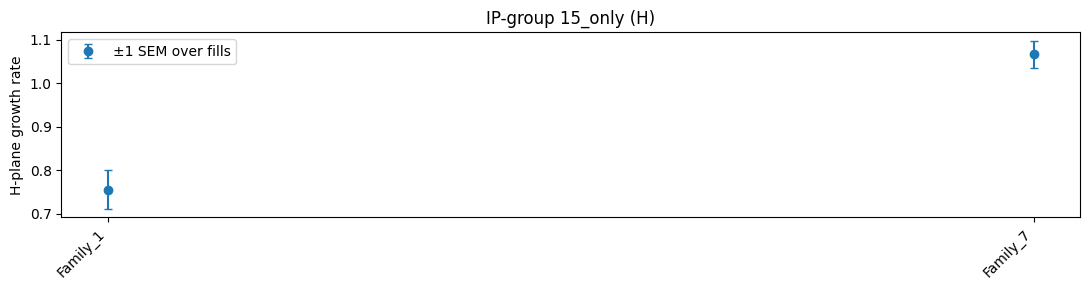

In [ ]:
from __future__ import annotations
import warnings
from typing import Iterable, Mapping, Sequence

try:
    from enum import StrEnum          
except ImportError:                    
    from enum import Enum

    class StrEnum(str, Enum): 
        """Fallback for Python versions lacking enum.StrEnum."""
        def _generate_next_value_(name, start, count, last_values):
            return name

THRESHOLD        = 1e11       # intensity cut to define t0
PLANE            = "H"        # default plane for summary plots
FIGSIZE          = (9, 3)

F_SCALE          = 0.1
REL_ERR          = 0.05       # 5 % rel error
ABS_ERR_FLOOR    = 0.02       # emittance units
MIN_ERR          = 1e-12
MIN_PTS          = 5
MIN_DT_H         = 0.15       # hours  (≈ 9 min)
MAX_WEIGHT       = 1e4

def _ip_collision_sets_for_fill(fillno: int, beam: str, rawdata: Path
) -> dict[str, set[int]]:

    fpat = LHCFillingPattern(fillno, rawdata)
    side = "B1" if beam.upper() == "B1" else "B2"

    ip15 = fpat.collbid_ip15[side]
    ip2  = fpat.collbid_ip2 [side]
    ip8  = fpat.collbid_ip8 [side]

    return {"15": set(map(int, ip15)),
            "2":  set(map(int, ip2)),
            "8":  set(map(int, ip8))}

def _classify_slots_by_ip(
    slots: Sequence[int],
    set15: set[int], set2: set[int], set8: set[int],
) -> dict[str, np.ndarray]:

    slots = np.asarray(slots, dtype=int)

    # fast vectorised membership
    in15, in2, in8 = (np.isin(slots, list(s)) for s in (set15, set2, set8))

    m15_only   =  in15 & ~in2 & ~in8
    m2_only    = ~in15 &  in2 & ~in8
    m8_only    = ~in15 & ~in2 &  in8
    m15_2      =  in15 &  in2 & ~in8
    m15_8      =  in15 & ~in2 &  in8
    m2_8       = ~in15 &  in2 &  in8
    m15_2_8    =  in15 &  in2 &  in8
    mnone      = ~(in15 | in2 | in8)

    return {
        "15_only": slots[m15_only],
        "2_only":  slots[m2_only],
        "8_only":  slots[m8_only],
        "15_2":    slots[m15_2],
        "15_8":    slots[m15_8],
        "2_8":     slots[m2_8],
        "15_2_8":  slots[m15_2_8],
        "none":    slots[mnone],
    }

def build_family_ip_partitions(
    fams_by_fill: Mapping[int, Mapping[str, Sequence[int]]],
    rawdata: Path,
    beam: str,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns
    -------
    df_ip_long : columns (fill, family, ip_group, slot)
    df_ip_summary : columns (fill, family, …group counts…)
    """
    long_records, summary_records = [], []

    for fillno, fams in fams_by_fill.items():
        ip_sets = _ip_collision_sets_for_fill(fillno, beam, rawdata)
        set15, set2, set8 = ip_sets["15"], ip_sets["2"], ip_sets["8"]

        for fam, slots in fams.items():
            slots = np.asarray(slots, dtype=int)
            partitions = _classify_slots_by_ip(slots, set15, set2, set8)

            # long form
            for ipg, arr in partitions.items():
                for s in arr:
                    long_records.append({"fill": fillno,
                                         "family": fam,
                                         "ip_group": ipg,
                                         "slot": int(s)})
            # summary counts
            rec = {"fill": fillno, "family": fam}
            rec.update({ipg: len(arr) for ipg, arr in partitions.items()})
            summary_records.append(rec)

    df_long = (pd.DataFrame(long_records)
                 .sort_values(["fill", "family", "ip_group", "slot"])
                 .reset_index(drop=True))
    df_sum  = (pd.DataFrame(summary_records)
                 .sort_values(["fill", "family"])
                 .reset_index(drop=True))
    return df_long, df_sum


# --------------------------------------------------------------------------
# 3.  Robust weighted line fit
# --------------------------------------------------------------------------
_line_model = Model(lambda x, m, b: m * x + b)

def robust_line(x_hours: np.ndarray, y: np.ndarray, f_scale=F_SCALE):
    yerr = np.maximum(np.maximum(REL_ERR * np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w = 1.0 / yerr
    w = np.minimum(w, MAX_WEIGHT)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, module="lmfit")
        res = _line_model.fit(
            y, x=x_hours,
            m=0.0, b=y[0],
            weights=w,
            method="least_squares",
            fit_kws={"loss": "soft_l1", "f_scale": f_scale},
        )

    m = res.params["m"].value
    b = res.params["b"].value
    sm = res.params["m"].stderr or np.nan
    return m, b, sm, res


# --------------------------------------------------------------------------
# 4.  Per-fill family-level robust slopes
# --------------------------------------------------------------------------
def _wmean_and_ci(pairs: Sequence[tuple[float, float]]
) -> tuple[float, float, float, float, float, float, int]:
    """Weighted mean ± CI, plus spread stats, from (value, sigma) pairs."""
    if not pairs:
        return (np.nan,) * 6 + (0,)

    vals, sigs = map(np.asarray, zip(*pairs))
    ok = np.isfinite(vals) & np.isfinite(sigs) & (sigs > 0)
    if ok.sum() == 0:
        return (np.nan,) * 6 + (0,)

    w = 1.0 / sigs[ok] ** 2
    mean = np.sum(w * vals[ok]) / np.sum(w)
    sem  = (1.0 / np.sum(w)) ** 0.5
    ci95 = 1.96 * sem
    std  = np.std(vals[ok], ddof=1) if ok.sum() > 1 else np.nan
    mad  = 1.4826 * np.median(np.abs(vals[ok] - np.median(vals[ok]))) \
           if ok.sum() > 1 else np.nan
    return mean, sem, mean - ci95, mean + ci95, std, mad, int(ok.sum())


def one_fill_family_rates_robust(
    fno: int,
    beam: str,
    families: Mapping[str, Sequence[int]],
    fbmodes: pd.DataFrame,
    rawdata: Path,
    threshold: float = THRESHOLD,
) -> tuple[pd.DataFrame, dict]:
    """
    Returns
    -------
    df : index (fill, family) with H_*/V_* statistics
    fits : nested dict[fam][slot] → (H tuple, V tuple)  (for drill-downs)
    """
    bsrt_loc = "5R4" if beam.upper() == "B1" else "5L4"

    int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
    H_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
    V_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"

    def load_INJPHYS(var: str) -> pd.Series:
        sub = fbmodes.loc[fno]
        rows = sub.query("BMODE=='INJPHYS'").sort_values("tsStart")
        if rows.empty:
            rows = sub.sort_values("tsStart").iloc[[0]]
        t0, t1 = map(pd.to_datetime, (rows["tsStart"].iloc[0],
                                      rows["tsEnd"].iloc[0]))
        parts = []
        pq_dir = rawdata / f"HX:FILLN={fno}"
        for pq in pq_dir.rglob("*.parquet"):
            try:
                df = pd.read_parquet(pq, columns=[var])
            except Exception as exc:
                warnings.warn(f"Skipping {pq} ({exc})", UserWarning)
                continue
            ser = df[var]
            ser.index = pd.to_datetime(df.index, errors="coerce")
            parts.append(ser.dropna())
        if not parts:
            raise RuntimeError(f"No data for PV {var!r} in fill {fno}")
        full = pd.concat(parts).sort_index()
        return full.loc[t0:t1]

    def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
        return ser.apply(
            lambda a: a[slot] if hasattr(a, "__len__") and len(a) > slot else np.nan
        )

    def segment_ok(seg: pd.Series) -> bool:
        if seg is None or seg.empty or len(seg) < MIN_PTS:
            return False
        dt_h = (seg.index[-1] - seg.index[0]).total_seconds() / 3600.0
        return dt_h >= MIN_DT_H

    I  = load_INJPHYS(int_var)
    EH = load_INJPHYS(H_var)
    EV = load_INJPHYS(V_var)

    per_h: dict[int, tuple[float, float]] = {}
    per_v: dict[int, tuple[float, float]] = {}
    fits: dict[str, dict[int, dict[str, tuple]]] = {}

    for fam, slots in families.items():
        fits[fam] = {}
        for slot in slots:
            Ii = extract_slot(I, slot)
            above = Ii[Ii >= threshold]
            if above.empty:
                per_h[slot] = per_v[slot] = (np.nan, np.nan)
                continue
            t0 = above.index[0]
            Hs = extract_slot(EH, slot).loc[t0:].dropna()
            Vs = extract_slot(EV, slot).loc[t0:].dropna()

            if not (segment_ok(Hs) and segment_ok(Vs)):
                per_h[slot] = per_v[slot] = (np.nan, np.nan)
                continue

            xh = (Hs.index - t0).total_seconds() / 3600.0
            xv = (Vs.index - t0).total_seconds() / 3600.0
            sh, ih, sh_err, _ = robust_line(xh, Hs.values)
            sv, iv, sv_err, _ = robust_line(xv, Vs.values)
            per_h[slot] = (sh, sh_err)
            per_v[slot] = (sv, sv_err)
            fits[fam][slot] = {"H": (sh, ih, sh_err, t0, Hs),
                               "V": (sv, iv, sv_err, t0, Vs)}

    rows = []
    for fam, slots in families.items():
        h_pairs = [per_h[s] for s in slots if s in per_h]
        v_pairs = [per_v[s] for s in slots if s in per_v]

        H_mean, H_sem, H_lo95, H_hi95, H_std, H_mad, H_n = _wmean_and_ci(h_pairs)
        V_mean, V_sem, V_lo95, V_hi95, V_std, V_mad, V_n = _wmean_and_ci(v_pairs)

        rows.append({
            "fill": fno,
            "family": fam,
            "H_rate_mean_w": H_mean,
            "H_err_family":  H_sem,
            "H_lo95":        H_lo95,
            "H_hi95":        H_hi95,
            "H_std_slots":   H_std,
            "H_mad_slots":   H_mad,
            "H_n_slots":     H_n,
            "V_rate_mean_w": V_mean,
            "V_err_family":  V_sem,
            "V_lo95":        V_lo95,
            "V_hi95":        V_hi95,
            "V_std_slots":   V_std,
            "V_mad_slots":   V_mad,
            "V_n_slots":     V_n,
        })

    df = pd.DataFrame(rows).set_index(["fill", "family"])
    return df, fits
#   Plot helpers
def plot_slot_with_fit(slot_fit_tuple, plane="H", figsize=FIGSIZE, label=None):
    slope, intercept, _, t0, ser = slot_fit_tuple
    x = (ser.index - t0).total_seconds() / 3600.0
    y_fit = intercept + slope * x

    plt.figure(figsize=figsize)
    plt.plot(ser.index, ser.values, label="Raw", alpha=0.6)
    plt.plot(ser.index, y_fit, label="Weighted robust fit", linewidth=2)
    plt.xlabel("Time"); plt.ylabel(f"Emittance {plane}")
    plt.title(label or "Slot"); plt.legend(); plt.tight_layout(); plt.show()


def plot_ip_group(
    df_mean: pd.DataFrame,
    plane: str = "H",
    ipg: str = "15_only",
    err: str = "sem",
    figsize: tuple[int, int] = (11, 3),
):
    """One bar-plot panel for a given IP-group over all families."""
    sub = df_mean.query("ip_group == @ipg")
    fams = sub["family"]
    means = sub[f"{plane}_mean"]
    if err.lower() == "sem":
        yerr = sub[f"{plane}_sem"]
        label = "±1 SEM over fills"
    else:
        ci = 1.96 * sub[f"{plane}_sem"]
        yerr = np.vstack([ci, ci])
        label = "±95 % CI"

    fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(fams, means, yerr=yerr, fmt="o", capsize=3,
                elinewidth=1.5, label=label)
    ax.set_xticklabels(fams, rotation=45, ha="right")
    ax.set_ylabel(f"{plane}-plane growth rate")
    ax.set_title(f"IP-group {ipg} ({plane})")
    ax.legend(); fig.tight_layout(); plt.show()

def analyse_and_plot(
    fills: Iterable[int],
    beam: str,
    ip: int | str,
    rawdata: Path,
    fbmodes: pd.DataFrame,
    build_families_for_fill,   
    plane: str = PLANE,
    threshold: float = THRESHOLD,
):
    fams_by_fill = {
        fno: build_families_for_fill(fno, beam=beam, ip=ip, RAWDATA=rawdata)
        for fno in fills
    }
    df_ip_long, _ = build_family_ip_partitions(
        fams_by_fill=fams_by_fill, rawdata=rawdata, beam=beam
    )
    ip_tables, ip_fits = [], {}
    for fno in fills:
        df_fill = df_ip_long.query("fill == @fno")
        for ipg, grp in df_fill.groupby("ip_group"):
            fams_ip = {fam: g["slot"].to_numpy()
                       for fam, g in grp.groupby("family")}
            df_rates, fits_this = one_fill_family_rates_robust(
                fno, beam, fams_ip, fbmodes, rawdata, threshold
            )
            df_rates = df_rates.reset_index()
            df_rates["ip_group"] = ipg
            ip_tables.append(df_rates)
            ip_fits.setdefault(ipg, {})[fno] = fits_this
    #average over fills
    df_all = (pd.concat(ip_tables, ignore_index=True)
                .set_index(["ip_group", "family", "fill"])
                .sort_index())

    df_mean = (df_all
                 .groupby(["ip_group", "family"])
                 .agg(H_mean=("H_rate_mean_w", "mean"),
                      H_sem =("H_rate_mean_w", "sem"),
                      V_mean=("V_rate_mean_w", "mean"),
                      V_sem =("V_rate_mean_w", "sem"),
                      n_fills=("H_rate_mean_w", "size"))
                 .reset_index())
    for ipg in df_mean["ip_group"].unique():
        plot_ip_group(df_mean, plane=plane, ipg=ipg, err="sem")

    return df_mean, ip_fits


if __name__ == "__main__":
    df_mean, fits = analyse_and_plot(
        fills, beam, ip, RAWDATA, fbmodes, build_families_for_fill
    )
    df_mean.to_csv("ip_family_slopes.csv")
df_mean, fits = analyse_and_plot(
         fills=fills,
         beam=beam,
         ip=ip,
         rawdata=RAWDATA,
         fbmodes=fbmodes,
         build_families_for_fill=build_families_for_fill,
     )
    #
df_mean.to_csv("family_ip_growth_rates.csv")


# STable


=== IP‑group 15_2  (14 fills) ===


Family_2                                Family_3            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.141620  0.208263 -0.163569  0.206531 -0.150124  0.228582   
2h since lvl-on  0.224476  0.145531  0.184383  0.128759  0.218080  0.145975   
3h since lvl-on  0.165957  0.098970  0.145149  0.088667  0.173434  0.102608   
4h since lvl-on  0.146929  0.077659  0.131183  0.070325  0.151766  0.079792   
5h since lvl-on  0.070926  0.006245  0.063045  0.006271  0.074049  0.012072   

                                     Family_4            ...  Family_5  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.175858  0.221337 -0.111498  0.194276  ... -0.172236   
2h since lvl-on  0.192179  0.134389  0.213803  0.134100  ...  0.199363   
3h since lvl-on  0.159059  0.098042  0.167547  0.089988  ...  0.156749   
4h since lvl-on  0.136099  0.072399  0.148124  0.071990  ...  0.138980   
5h since lvl-on  0.068841  0.009894  0.077113  0.010213  ...  0.066800   

                           Family_6                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.217783 -0.152855  0.214929 -0.154824  0.205826 -0.151556   
2h since lvl-on  0.142641  0.209796  0.147837  0.185063  0.130956  0.214903   
3h since lvl-on  0.095535  0.165967  0.099143  0.153577  0.093781  0.170416   
4h since lvl-on  0.073062  0.145061  0.078072  0.133309  0.070661  0.148665   
5h since lvl-on  0.010010  0.070096  0.012412  0.066509  0.010198  0.072929   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.220195 -0.184627  0.212457  
2h since lvl-on  0.149270  0.189595  0.134938  
3h since lvl-on  0.102418  0.156859  0.097376  
4h since lvl-on  0.080121  0.135822  0.072703  
5h since lvl-on  0.013980  0.071261  0.011558  

[5 rows x 24 columns]

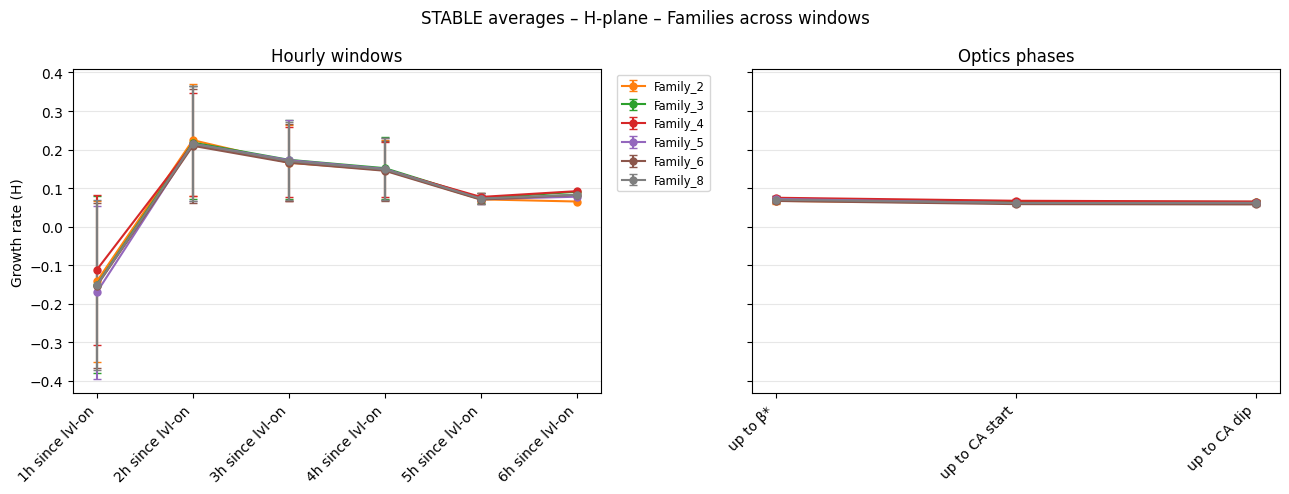


=== IP‑group 15_2_8  (14 fills) ===


Family_1                                Family_2            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.142524  0.194111 -0.136537  0.183306 -0.128789  0.186359   
2h since lvl-on  0.193476  0.134759  0.183480  0.120057  0.203244  0.136083   
3h since lvl-on  0.147312  0.091901  0.146950  0.084924  0.158630  0.093200   
4h since lvl-on  0.129823  0.071710  0.121077  0.057684  0.143378  0.075018   
5h since lvl-on  0.056233  0.008857  0.059914  0.005871  0.064009  0.008339   

                                     Family_3            ...  Family_6  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.126726  0.179121 -0.141023  0.201085  ... -0.146931   
2h since lvl-on  0.188976  0.121016  0.205177  0.138628  ...  0.181701   
3h since lvl-on  0.158240  0.087626  0.161731  0.094024  ...  0.151675   
4h since lvl-on  0.134008  0.059500  0.145169  0.075543  ...  0.131559   
5h since lvl-on  0.068932  0.005060  0.060569  0.008145  ...  0.059017   

                           Family_7                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.189963 -0.180967  0.235629 -0.177546  0.216490 -0.143971   
2h since lvl-on  0.124855  0.209855  0.153714  0.188593  0.137706  0.207261   
3h since lvl-on  0.089149  0.160451  0.102018  0.154419  0.098260  0.161728   
4h since lvl-on  0.066365  0.140585  0.080227  0.133122  0.074191  0.144071   
5h since lvl-on  0.005457  0.054062  0.007042  0.052458  0.004556  0.060953   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.204351 -0.147203  0.193956  
2h since lvl-on  0.141044  0.186685  0.125294  
3h since lvl-on  0.095578  0.155001  0.089493  
4h since lvl-on  0.076343  0.134976  0.067034  
5h since lvl-on  0.008828  0.061798  0.005404  

[5 rows x 32 columns]

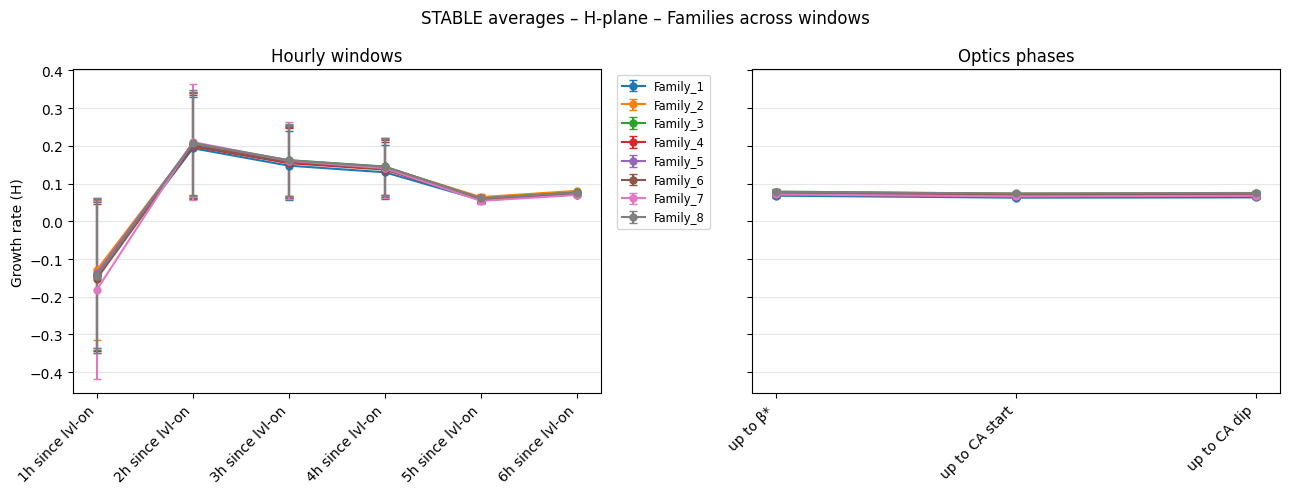


=== IP‑group 15_8  (14 fills) ===


Family_1                                Family_2            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.126918  0.199220 -0.157102  0.195062 -0.111028  0.194326   
2h since lvl-on  0.203313  0.138928  0.179519  0.125300  0.230234  0.142271   
3h since lvl-on  0.155813  0.094501  0.148723  0.089484  0.179276  0.095728   
4h since lvl-on  0.135932  0.075049  0.128941  0.066360  0.159328  0.075079   
5h since lvl-on  0.056397  0.009465  0.059220  0.005414  0.078553  0.008373   

                                     Family_3            ...  Family_6  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.122598  0.196610 -0.132259  0.205210  ... -0.123937   
2h since lvl-on  0.201486  0.121789  0.226536  0.141952  ...  0.195070   
3h since lvl-on  0.174243  0.088721  0.180543  0.096065  ...  0.166786   
4h since lvl-on  0.150604  0.062520  0.159445  0.075651  ...  0.148318   
5h since lvl-on  0.083763  0.004725  0.071788  0.006733  ...  0.072959   

                           Family_7                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.195746 -0.180053  0.232516 -0.186704  0.218334 -0.131830   
2h since lvl-on  0.123237  0.213874  0.156345  0.185922  0.139073  0.231401   
3h since lvl-on  0.089288  0.164497  0.106026  0.153711  0.099459  0.181537   
4h since lvl-on  0.068740  0.142476  0.083091  0.133072  0.075244  0.160057   
5h since lvl-on  0.008398  0.054122  0.008256  0.052935  0.005405  0.077481   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.203141 -0.139900  0.191862  
2h since lvl-on  0.142080  0.200850  0.122088  
3h since lvl-on  0.095784  0.170496  0.090704  
4h since lvl-on  0.075582  0.149771  0.067781  
5h since lvl-on  0.010160  0.078466  0.006519  

[5 rows x 32 columns]

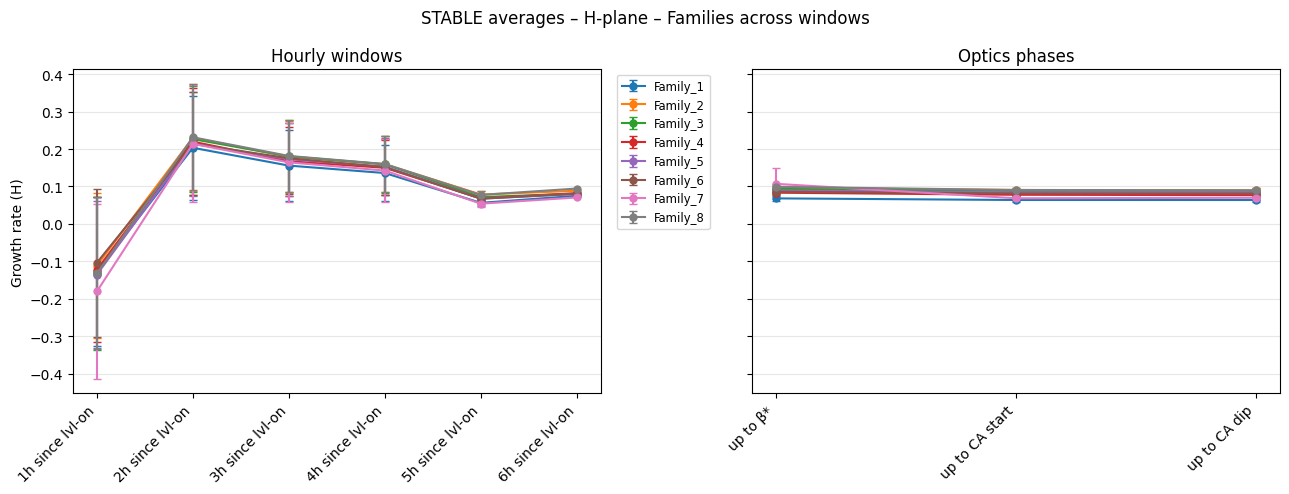


=== IP‑group 15_only  (14 fills) ===


Family_1                                Family_7            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.139147  0.197326 -0.127575  0.187022 -0.174045  0.247893   
2h since lvl-on  0.213651  0.136686  0.185952  0.116242  0.232978  0.165542   
3h since lvl-on  0.164175  0.091564  0.151089  0.081068  0.173819  0.112289   
4h since lvl-on  0.144120  0.072830  0.108710  0.036226  0.147882  0.087620   
5h since lvl-on  0.071093  0.011289  0.074450  0.008082  0.063589  0.009751   

                                     
                        V            
                     mean       sem  
window                               
1h since lvl-on -0.201991  0.239409  
2h since lvl-on  0.191658  0.147958  
3h since lvl-on  0.151068  0.102596  
4h since lvl-on  0.131671  0.079530  
5h since lvl-on  0.056056  0.006831

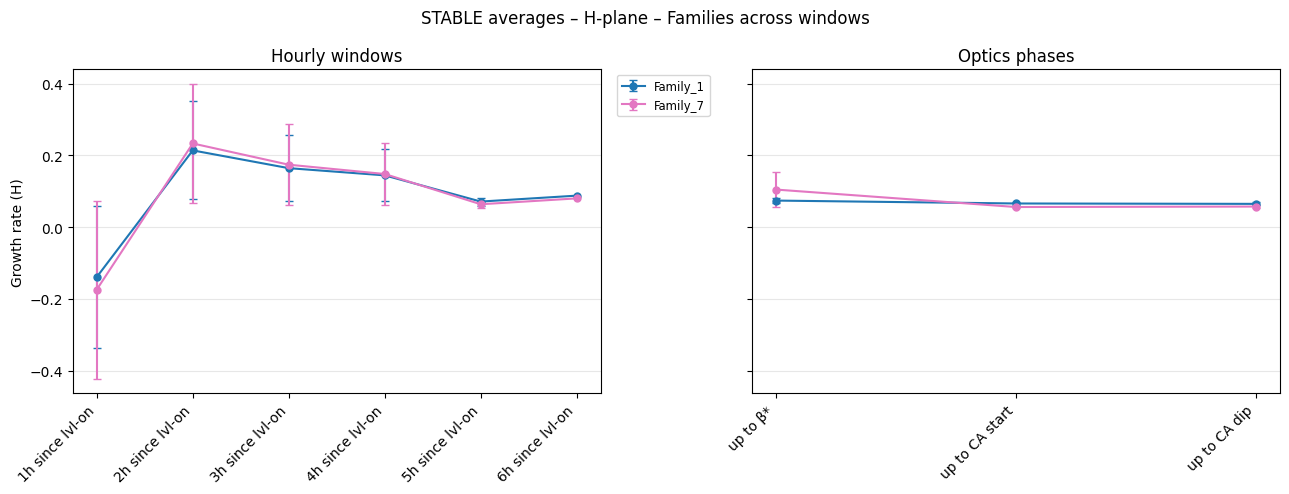

In [ ]:
ip              = 1
RAWDATA         = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/rawdata")

BETA_PV         = "HX:BETASTAR_IP1"
XING_PV         = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"
LEV_PV          = "LHC.LUMISERVER:LumiLevelingIP1:Enable"
THRESH_CA       = 120.0            # μrad

F_SCALE         = 0.1
REL_ERR         = 0.05
ABS_ERR_FLOOR   = 0.02
MIN_ERR         = 1e-12
MIN_PTS         = 5
MAX_WEIGHT      = 1e4
MAKE_HOURLY     = True

FAMILY_COLORS = {
    "Family_1": "#1f77b4", "Family_2": "#ff7f0e", "Family_3": "#2ca02c",
    "Family_4": "#d62728", "Family_5": "#9467bd", "Family_6": "#8c564b",
    "Family_7": "#e377c2", "Family_8": "#7f7f7f",
}

def _utc(ts) -> pd.Timestamp:
    """Return tz‑aware UTC timestamp."""
    ts = pd.Timestamp(ts)
    return ts.tz_localize("UTC") if ts.tzinfo is None else ts.tz_convert("UTC")


def bsrt_loc_for_beam(b: str) -> str:
    return "5R4" if b.upper() == "B1" else "5L4"


def load_series(pv: str, fno: int, root: Path) -> pd.Series:
    """Load scalar parquet PV for *entire* fill; UTC index, sorted."""
    parts = []
    for pq in (root / f"HX:FILLN={fno}").rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[pv])
        except Exception:
            continue
        idx = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(pd.Series(df[pv].values, index=idx).dropna())
    ser = pd.concat(parts, sort=True) if parts else pd.Series(dtype=float)
    return ser.sort_index()


def load_STABLE_series(pv: str, fno: int) -> pd.Series:
    """Return PV restricted to STABLE, UTC index, monotonic, no dups."""
    sub = fbmodes.loc[fno].sort_values("tsStart")
    stable = sub[sub["BMODE"].str.upper() == "STABLE"]
    if stable.empty:
        raise RuntimeError(f"No STABLE period for fill {fno}")
    t0 = _utc(stable["tsStart"].iloc[0])
    t1 = _utc(stable["tsEnd"  ].iloc[-1])

    ser = load_series(pv, fno, RAWDATA).sort_index()
    ser = ser[~ser.index.duplicated(keep="first")]
    return ser.loc[t0:t1]


def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    return ser.map(
        lambda a: a[slot] if hasattr(a, "__len__") and len(a) > slot else np.nan
    )

_line_model = Model(lambda x, m, b: m * x + b)

def robust_line(xh: np.ndarray, y: np.ndarray):
    yerr = np.maximum(np.maximum(REL_ERR * np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = np.minimum(1.0 / yerr, MAX_WEIGHT)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        res = _line_model.fit(
            y, x=xh, m=0.0, b=y[0], weights=w,
            method="least_squares",
            fit_kws={"loss": "soft_l1", "f_scale": F_SCALE}
        )
    m, b = res.params["m"].value, res.params["b"].value
    sm   = res.params["m"].stderr or np.nan
    return m, b, sm


def _wmean_sem(pairs):
    if not pairs:
        return np.nan, np.nan, 0
    vals, errs = map(np.asarray, zip(*pairs))
    ok = np.isfinite(vals) & np.isfinite(errs) & (errs > 0)
    if ok.sum() == 0:
        return np.nan, np.nan, 0
    w = 1.0 / errs[ok] ** 2
    mean = np.sum(w * vals[ok]) / np.sum(w)
    sem  = (1.0 / np.sum(w)) ** 0.5
    return mean, sem, int(ok.sum())

def leveling_on_time(fno):
    lev = load_series(LEV_PV, fno, RAWDATA).astype(float).dropna()
    d   = lev.diff().fillna(0)
    t_edge = d[d > 0].index.min()
    t_val  = lev[lev > 0].index.min()
    return _utc(min([t for t in (t_edge, t_val) if pd.notna(t)]))


def phase_markers(fno):
    beta = load_STABLE_series(BETA_PV, fno)
    xing = load_STABLE_series(XING_PV, fno)
    ca0  = xing.iloc[0]

    # β* plateau start (longest flat run)
    runs, rs, vp = [], beta.index[0], beta.iloc[0]
    for t, v in beta.iloc[1:].items():
        if v != vp:
            runs.append((rs, t)); rs, vp = t, v
    runs.append((rs, beta.index[-1]))
    t_beta_final = _utc(max(runs, key=lambda r: r[1] - r[0])[0])

    # CA markers
    idx_leave = np.where(xing.values != ca0)[0]
    t_ca_start = _utc(xing.index[idx_leave[0]] if idx_leave.size else xing.index[-1])
    idx_dip = np.where((xing.values <= THRESH_CA) & (xing.index > t_ca_start))[0]
    t_ca_dip = _utc(xing.index[idx_dip[0]] if idx_dip.size else xing.index[-1])

    return dict(lvl_on=leveling_on_time(fno),
                beta_final=t_beta_final,
                ca_start=t_ca_start,
                ca_dip=t_ca_dip)


def build_windows(t0: pd.Timestamp, markers, ser_H: pd.Series):
    eps = pd.Timedelta(seconds=1)
    wins = []

    if MAKE_HOURLY:
        last = markers["beta_final"] - pd.Timedelta(hours=1)
        current, hour = t0, 1
        while current + pd.Timedelta(hours=1) <= last:
            current += pd.Timedelta(hours=1)
            wins.append((f"{hour}h since lvl-on", current))
            hour += 1

    names = {"beta_final": "β*", "ca_start": "CA start", "ca_dip": "CA dip"}
    for key in ("beta_final", "ca_start", "ca_dip"):
        tend = markers[key]
        if tend - t0 > eps:
            wins.append((f"up to {names[key]}", tend))

    tend_data = ser_H.index.max()
    clean = [(lab, min(tend, tend_data)) for lab, tend in wins
             if min(tend, tend_data) - t0 > eps]
    return clean

def cumulative_rates_one_fill(fno, beam, fams_ip):
    marks = phase_markers(fno); t0 = marks["lvl_on"]

    bsrt_loc = bsrt_loc_for_beam(beam)
    ser_H = load_STABLE_series(f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H", fno)
    ser_V = load_STABLE_series(f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V", fno)

    windows = build_windows(t0, marks, ser_H)
    rawH = {s: extract_slot(ser_H, s) for slots in fams_ip.values() for s in slots}
    rawV = {s: extract_slot(ser_V, s) for slots in fams_ip.values() for s in slots}

    recs = []
    for label, tend in windows:
        for fam, slots in fams_ip.items():
            H_pairs, V_pairs = [], []
            for s in slots:
                segH = rawH[s].loc[t0:tend].dropna()
                if len(segH) >= MIN_PTS:
                    xh = (segH.index - t0).total_seconds() / 3600.0
                    sh, _, sh_e = robust_line(xh, segH.values)
                    if sh_e > 0: H_pairs.append((sh, sh_e))
                segV = rawV[s].loc[t0:tend].dropna()
                if len(segV) >= MIN_PTS:
                    xv = (segV.index - t0).total_seconds() / 3600.0
                    sv, _, sv_e = robust_line(xv, segV.values)
                    if sv_e > 0: V_pairs.append((sv, sv_e))
            H_m, H_s, _ = _wmean_sem(H_pairs)
            V_m, V_s, _ = _wmean_sem(V_pairs)
            recs.append(dict(window=label, family=fam,
                             H_mean=H_m, H_sem=H_s,
                             V_mean=V_m, V_sem=V_s))
    return (pd.DataFrame(recs)
              .set_index(["window", "family"])
              .sort_index())

def aggregate_over_fills(tables):
    big = pd.concat(tables, keys=range(len(tables)), names=["fill"])
    cols = {}
    for fam in big.index.get_level_values("family").unique():
        sub = big.xs(fam, level="family")
        for pl in ("H", "V"):
            grp = sub.groupby(level="window")[f"{pl}_mean"]
            cols[(fam, pl, "mean")] = grp.mean()
            cols[(fam, pl, "sem")]  = grp.sem()
    df = pd.concat(cols, axis=1).sort_index(axis=1)
    df.index.name = "window"
    return df

def plot_stable_avg_split_lines(stable_avg, plane="H"):
    hourly = [w for w in stable_avg.index if "h since" in w]
    optics = [w for w in ("up to β*", "up to CA start", "up to CA dip")
              if w in stable_avg.index]
    fams = sorted({f for f, pl, _ in stable_avg.columns if pl == plane})

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
    for ax, wins, title in zip(axes, [hourly, optics],
                               ["Hourly windows", "Optics phases"]):
        x = np.arange(len(wins)) * 1.2
        for fam in fams:
            m = stable_avg.loc[wins, (fam, plane, "mean")].to_numpy()
            e = stable_avg.loc[wins, (fam, plane, "sem" )].to_numpy()
            ax.errorbar(x, m, yerr=e, fmt="-o", capsize=3, ms=5,
                        color=FAMILY_COLORS.get(fam),
                        label=fam if ax is axes[0] else None)
        ax.set_xticks(x); ax.set_xticklabels(wins, rotation=45, ha="right")
        ax.set_title(title); ax.grid(axis="y", alpha=0.3)
    axes[0].set_ylabel(f"Growth rate ({plane})")
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
    fig.suptitle(f"STABLE averages – {plane}-plane – Families across windows")
    fig.tight_layout(); plt.show()

def main():
    fams_by_fill = {
        f: build_families_for_fill(f, beam=beam, ip=ip, RAWDATA=RAWDATA)
        for f in fills
    }
    df_ip_long, _ = build_family_ip_partitions(fams_by_fill, RAWDATA, beam)

    per_ip = {}
    for fno in fills:
        for ipg, grp in df_ip_long.query("fill == @fno").groupby("ip_group"):
            fams_ip = {fam: g["slot"].to_numpy()
                       for fam, g in grp.groupby("family")}
            per_ip.setdefault(ipg, []).append(
                cumulative_rates_one_fill(fno, beam, fams_ip)
            )

    for ipg, tbls in per_ip.items():
        stable_avg = aggregate_over_fills(tbls)
        print(f"\n=== IP‑group {ipg}  ({len(tbls)} fills) ===")
        display(stable_avg.head())
        plot_stable_avg_split_lines(stable_avg, plane="H")   # switch to 'V' if needed

# ---------------------------------------------------------------------
if __name__ == "__main__":
    for name in ("fbmodes", "fills", "beam",
                 "build_families_for_fill", "build_family_ip_partitions"):
        if name not in globals():
            raise RuntimeError(f"Define `{name}` before running this script.")
    main()


=== IP‑group 15_2  (14 fills) ===


Family_2                                Family_3            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.141620  0.208263 -0.163569  0.206531 -0.150124  0.228582   
2h since lvl-on  0.224476  0.145531  0.184383  0.128759  0.218080  0.145975   
3h since lvl-on  0.165957  0.098970  0.145149  0.088667  0.173434  0.102608   
4h since lvl-on  0.146929  0.077659  0.131183  0.070325  0.151766  0.079792   
5h since lvl-on  0.070926  0.006245  0.063045  0.006271  0.074049  0.012072   

                                     Family_4            ...  Family_5  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.175858  0.221337 -0.111498  0.194276  ... -0.172236   
2h since lvl-on  0.192179  0.134389  0.213803  0.134100  ...  0.199363   
3h since lvl-on  0.159059  0.098042  0.167547  0.089988  ...  0.156749   
4h since lvl-on  0.136099  0.072399  0.148124  0.071990  ...  0.138980   
5h since lvl-on  0.068841  0.009894  0.077113  0.010213  ...  0.066800   

                           Family_6                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.217783 -0.152855  0.214929 -0.154824  0.205826 -0.151556   
2h since lvl-on  0.142641  0.209796  0.147837  0.185063  0.130956  0.214903   
3h since lvl-on  0.095535  0.165967  0.099143  0.153577  0.093781  0.170416   
4h since lvl-on  0.073062  0.145061  0.078072  0.133309  0.070661  0.148665   
5h since lvl-on  0.010010  0.070096  0.012412  0.066509  0.010198  0.072929   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.220195 -0.184627  0.212457  
2h since lvl-on  0.149270  0.189595  0.134938  
3h since lvl-on  0.102418  0.156859  0.097376  
4h since lvl-on  0.080121  0.135822  0.072703  
5h since lvl-on  0.013980  0.071261  0.011558  

[5 rows x 24 columns]

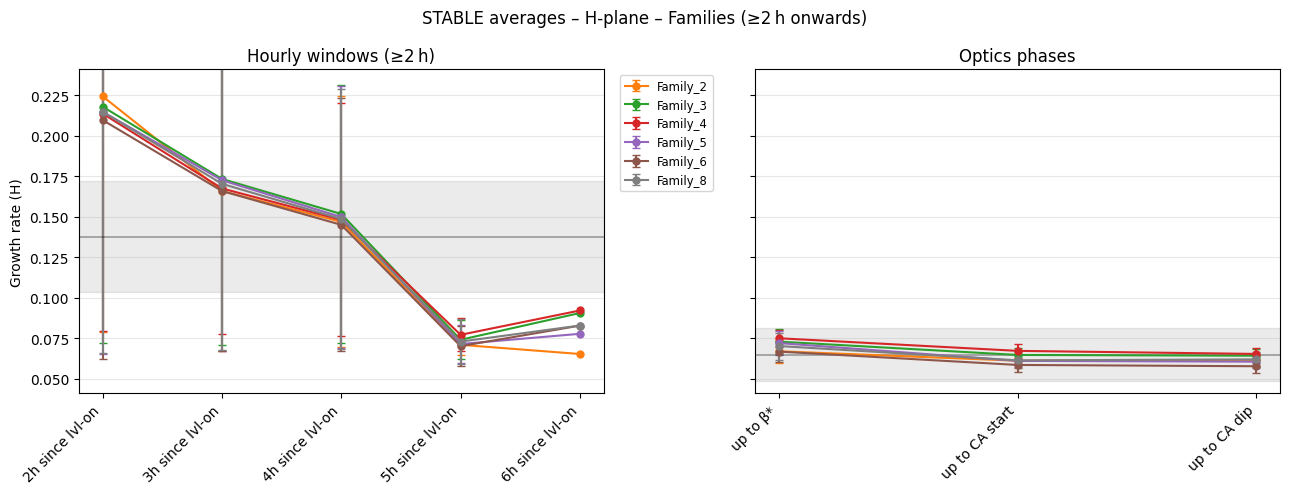


=== IP‑group 15_2_8  (14 fills) ===


Family_1                                Family_2            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.142524  0.194111 -0.136537  0.183306 -0.128789  0.186359   
2h since lvl-on  0.193476  0.134759  0.183480  0.120057  0.203244  0.136083   
3h since lvl-on  0.147312  0.091901  0.146950  0.084924  0.158630  0.093200   
4h since lvl-on  0.129823  0.071710  0.121077  0.057684  0.143378  0.075018   
5h since lvl-on  0.056233  0.008857  0.059914  0.005871  0.064009  0.008339   

                                     Family_3            ...  Family_6  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.126726  0.179121 -0.141023  0.201085  ... -0.146931   
2h since lvl-on  0.188976  0.121016  0.205177  0.138628  ...  0.181701   
3h since lvl-on  0.158240  0.087626  0.161731  0.094024  ...  0.151675   
4h since lvl-on  0.134008  0.059500  0.145169  0.075543  ...  0.131559   
5h since lvl-on  0.068932  0.005060  0.060569  0.008145  ...  0.059017   

                           Family_7                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.189963 -0.180967  0.235629 -0.177546  0.216490 -0.143971   
2h since lvl-on  0.124855  0.209855  0.153714  0.188593  0.137706  0.207261   
3h since lvl-on  0.089149  0.160451  0.102018  0.154419  0.098260  0.161728   
4h since lvl-on  0.066365  0.140585  0.080227  0.133122  0.074191  0.144071   
5h since lvl-on  0.005457  0.054062  0.007042  0.052458  0.004556  0.060953   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.204351 -0.147203  0.193956  
2h since lvl-on  0.141044  0.186685  0.125294  
3h since lvl-on  0.095578  0.155001  0.089493  
4h since lvl-on  0.076343  0.134976  0.067034  
5h since lvl-on  0.008828  0.061798  0.005404  

[5 rows x 32 columns]

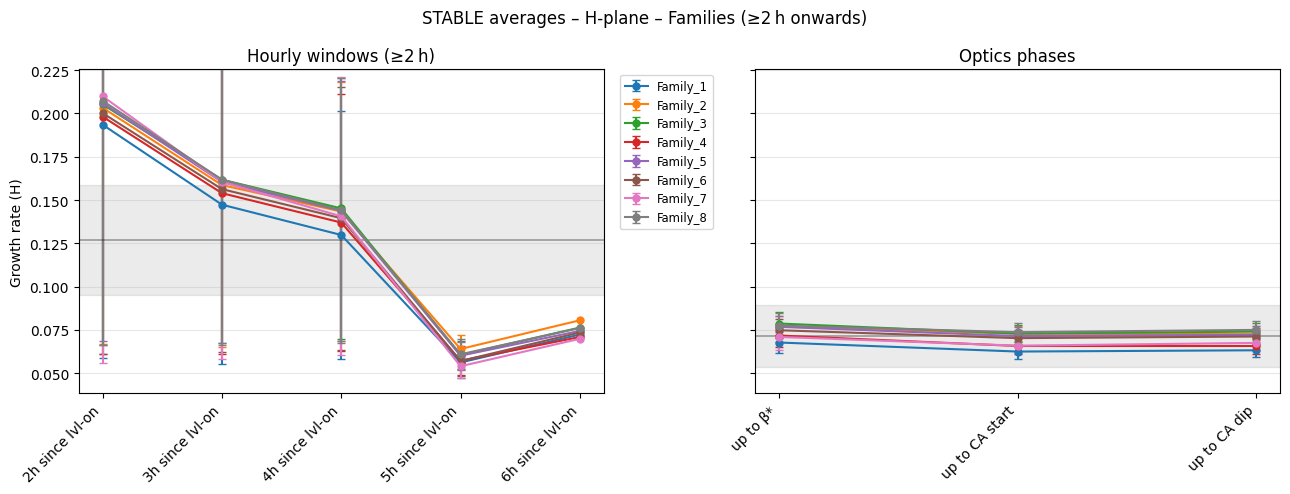


=== IP‑group 15_8  (14 fills) ===


Family_1                                Family_2            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.126918  0.199220 -0.157102  0.195062 -0.111028  0.194326   
2h since lvl-on  0.203313  0.138928  0.179519  0.125300  0.230234  0.142271   
3h since lvl-on  0.155813  0.094501  0.148723  0.089484  0.179276  0.095728   
4h since lvl-on  0.135932  0.075049  0.128941  0.066360  0.159328  0.075079   
5h since lvl-on  0.056397  0.009465  0.059220  0.005414  0.078553  0.008373   

                                     Family_3            ...  Family_6  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.122598  0.196610 -0.132259  0.205210  ... -0.123937   
2h since lvl-on  0.201486  0.121789  0.226536  0.141952  ...  0.195070   
3h since lvl-on  0.174243  0.088721  0.180543  0.096065  ...  0.166786   
4h since lvl-on  0.150604  0.062520  0.159445  0.075651  ...  0.148318   
5h since lvl-on  0.083763  0.004725  0.071788  0.006733  ...  0.072959   

                           Family_7                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.195746 -0.180053  0.232516 -0.186704  0.218334 -0.131830   
2h since lvl-on  0.123237  0.213874  0.156345  0.185922  0.139073  0.231401   
3h since lvl-on  0.089288  0.164497  0.106026  0.153711  0.099459  0.181537   
4h since lvl-on  0.068740  0.142476  0.083091  0.133072  0.075244  0.160057   
5h since lvl-on  0.008398  0.054122  0.008256  0.052935  0.005405  0.077481   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.203141 -0.139900  0.191862  
2h since lvl-on  0.142080  0.200850  0.122088  
3h since lvl-on  0.095784  0.170496  0.090704  
4h since lvl-on  0.075582  0.149771  0.067781  
5h since lvl-on  0.010160  0.078466  0.006519  

[5 rows x 32 columns]

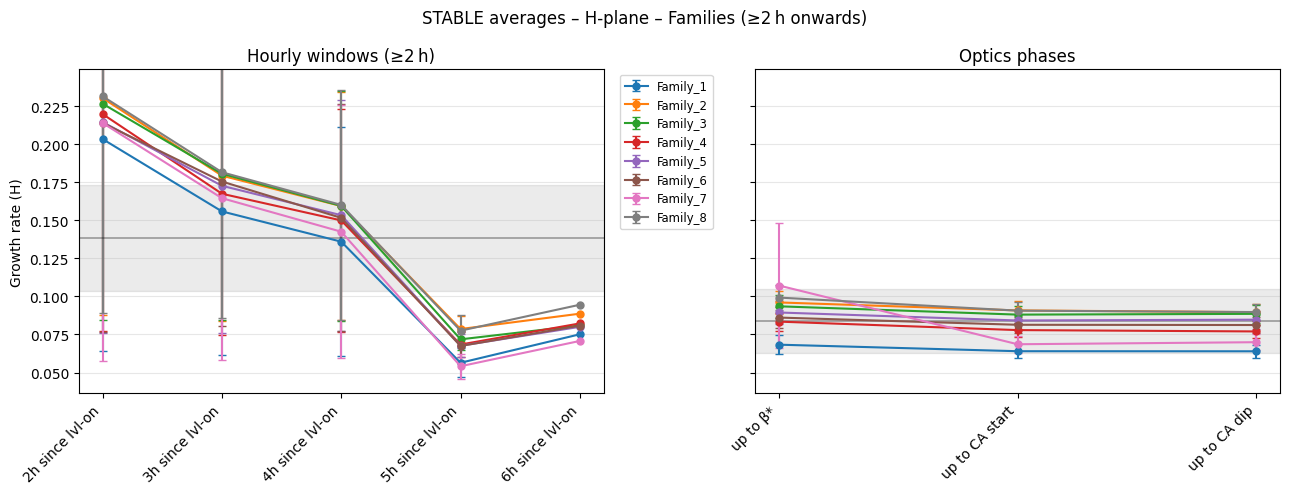


=== IP‑group 15_only  (14 fills) ===


Family_1                                Family_7            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.139147  0.197326 -0.127575  0.187022 -0.174045  0.247893   
2h since lvl-on  0.213651  0.136686  0.185952  0.116242  0.232978  0.165542   
3h since lvl-on  0.164175  0.091564  0.151089  0.081068  0.173819  0.112289   
4h since lvl-on  0.144120  0.072830  0.108710  0.036226  0.147882  0.087620   
5h since lvl-on  0.071093  0.011289  0.074450  0.008082  0.063589  0.009751   

                                     
                        V            
                     mean       sem  
window                               
1h since lvl-on -0.201991  0.239409  
2h since lvl-on  0.191658  0.147958  
3h since lvl-on  0.151068  0.102596  
4h since lvl-on  0.131671  0.079530  
5h since lvl-on  0.056056  0.006831

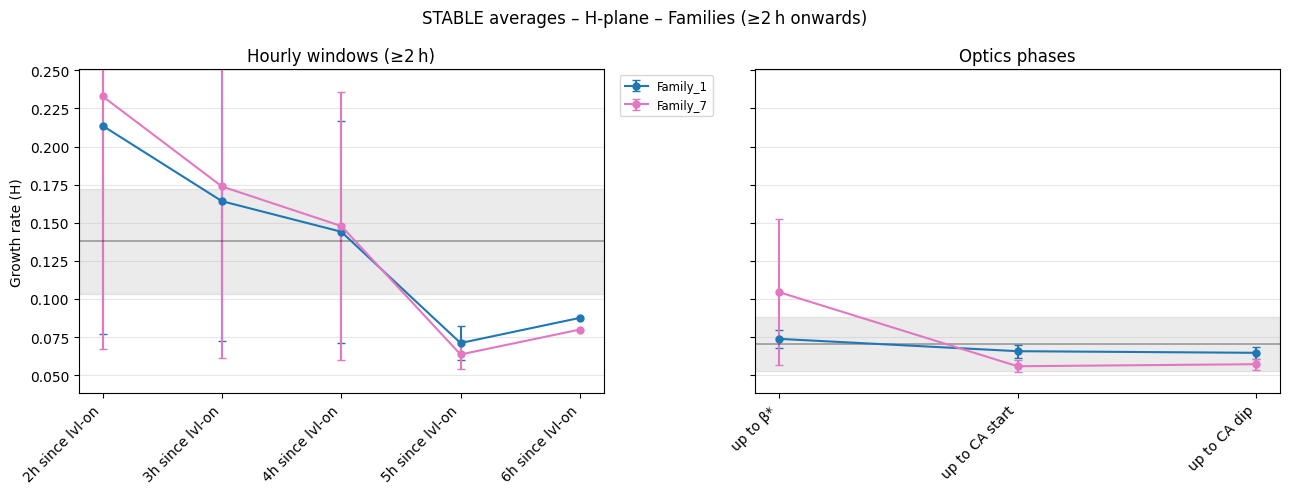

In [ ]:

def main(plane: str = "H"):
    fams_by_fill = {
        f: build_families_for_fill(f, beam=beam, ip=ip, RAWDATA=RAWDATA)
        for f in fills
    }

    df_ip_long, _ = build_family_ip_partitions(fams_by_fill, RAWDATA, beam)
    per_ip: dict[str, list[pd.DataFrame]] = {}
    for fno in fills:
        df_fill = df_ip_long.query("fill == @fno")
        for ipg, grp in df_fill.groupby("ip_group"):
            fams_ip = {fam: g["slot"].to_numpy()
                       for fam, g in grp.groupby("family")}
            per_ip.setdefault(ipg, []).append(
                cumulative_rates_one_fill(fno, beam, fams_ip)
            )
    avg_by_ip = {}
    for ipg, tbls in per_ip.items():
        stable_avg = aggregate_over_fills(tbls)
        avg_by_ip[ipg] = stable_avg         

        print(f"\n=== IP‑group {ipg}  ({len(tbls)} fills) ===")
        display(stable_avg.head())
        plot_stable_avg_split_lines(stable_avg, plane=plane)

    return avg_by_ip

# ---------------------------------------------------------------------
if __name__ == "__main__":
    for name in ("fbmodes", "fills", "beam",
                 "build_families_for_fill", "build_family_ip_partitions"):
        if name not in globals():
            raise RuntimeError(f"Define `{name}` before running this script.")
    avg_tables = main()           



=== IP‑group 15_2  (14 fills) ===


Family_2                                Family_3            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.141620  0.208263 -0.163569  0.206531 -0.150124  0.228582   
2h since lvl-on  0.224476  0.145531  0.184383  0.128759  0.218080  0.145975   
3h since lvl-on  0.165957  0.098970  0.145149  0.088667  0.173434  0.102608   
4h since lvl-on  0.146929  0.077659  0.131183  0.070325  0.151766  0.079792   
5h since lvl-on  0.070926  0.006245  0.063045  0.006271  0.074049  0.012072   

                                     Family_4            ...  Family_5  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.175858  0.221337 -0.111498  0.194276  ... -0.172236   
2h since lvl-on  0.192179  0.134389  0.213803  0.134100  ...  0.199363   
3h since lvl-on  0.159059  0.098042  0.167547  0.089988  ...  0.156749   
4h since lvl-on  0.136099  0.072399  0.148124  0.071990  ...  0.138980   
5h since lvl-on  0.068841  0.009894  0.077113  0.010213  ...  0.066800   

                           Family_6                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.217783 -0.152855  0.214929 -0.154824  0.205826 -0.151556   
2h since lvl-on  0.142641  0.209796  0.147837  0.185063  0.130956  0.214903   
3h since lvl-on  0.095535  0.165967  0.099143  0.153577  0.093781  0.170416   
4h since lvl-on  0.073062  0.145061  0.078072  0.133309  0.070661  0.148665   
5h since lvl-on  0.010010  0.070096  0.012412  0.066509  0.010198  0.072929   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.220195 -0.184627  0.212457  
2h since lvl-on  0.149270  0.189595  0.134938  
3h since lvl-on  0.102418  0.156859  0.097376  
4h since lvl-on  0.080121  0.135822  0.072703  
5h since lvl-on  0.013980  0.071261  0.011558  

[5 rows x 24 columns]

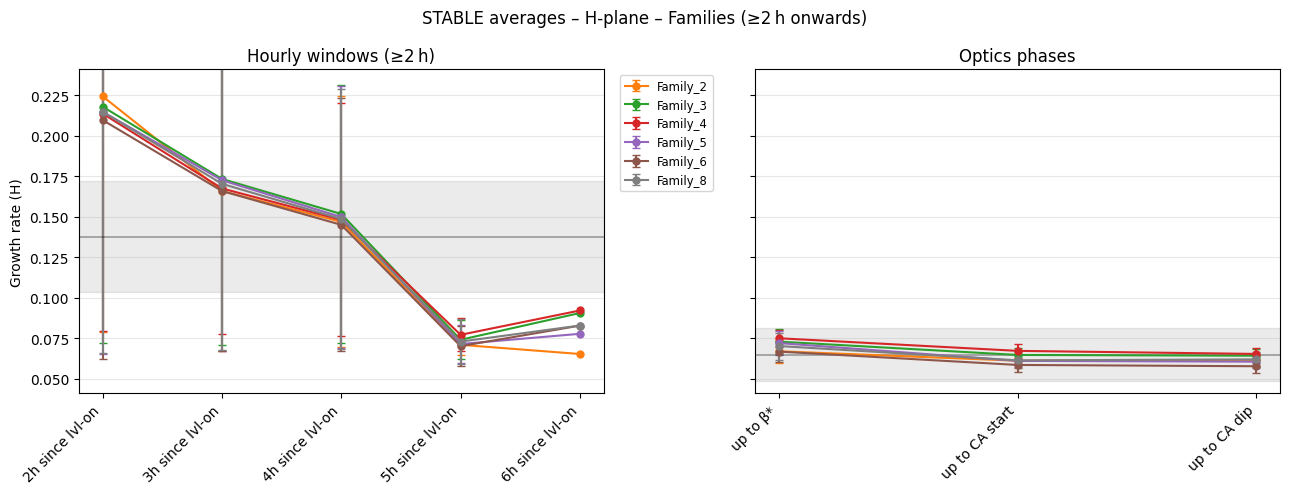


=== IP‑group 15_2_8  (14 fills) ===


Family_1                                Family_2            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.142524  0.194111 -0.136537  0.183306 -0.128789  0.186359   
2h since lvl-on  0.193476  0.134759  0.183480  0.120057  0.203244  0.136083   
3h since lvl-on  0.147312  0.091901  0.146950  0.084924  0.158630  0.093200   
4h since lvl-on  0.129823  0.071710  0.121077  0.057684  0.143378  0.075018   
5h since lvl-on  0.056233  0.008857  0.059914  0.005871  0.064009  0.008339   

                                     Family_3            ...  Family_6  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.126726  0.179121 -0.141023  0.201085  ... -0.146931   
2h since lvl-on  0.188976  0.121016  0.205177  0.138628  ...  0.181701   
3h since lvl-on  0.158240  0.087626  0.161731  0.094024  ...  0.151675   
4h since lvl-on  0.134008  0.059500  0.145169  0.075543  ...  0.131559   
5h since lvl-on  0.068932  0.005060  0.060569  0.008145  ...  0.059017   

                           Family_7                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.189963 -0.180967  0.235629 -0.177546  0.216490 -0.143971   
2h since lvl-on  0.124855  0.209855  0.153714  0.188593  0.137706  0.207261   
3h since lvl-on  0.089149  0.160451  0.102018  0.154419  0.098260  0.161728   
4h since lvl-on  0.066365  0.140585  0.080227  0.133122  0.074191  0.144071   
5h since lvl-on  0.005457  0.054062  0.007042  0.052458  0.004556  0.060953   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.204351 -0.147203  0.193956  
2h since lvl-on  0.141044  0.186685  0.125294  
3h since lvl-on  0.095578  0.155001  0.089493  
4h since lvl-on  0.076343  0.134976  0.067034  
5h since lvl-on  0.008828  0.061798  0.005404  

[5 rows x 32 columns]

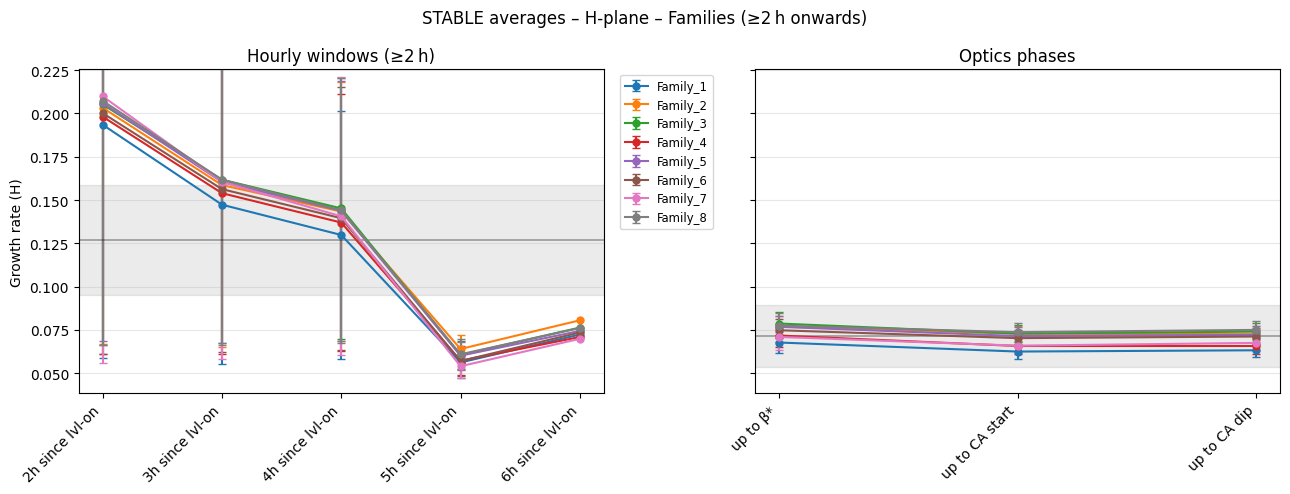


=== IP‑group 15_8  (14 fills) ===


Family_1                                Family_2            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.126918  0.199220 -0.157102  0.195062 -0.111028  0.194326   
2h since lvl-on  0.203313  0.138928  0.179519  0.125300  0.230234  0.142271   
3h since lvl-on  0.155813  0.094501  0.148723  0.089484  0.179276  0.095728   
4h since lvl-on  0.135932  0.075049  0.128941  0.066360  0.159328  0.075079   
5h since lvl-on  0.056397  0.009465  0.059220  0.005414  0.078553  0.008373   

                                     Family_3            ...  Family_6  \
                        V                   H            ...         V   
                     mean       sem      mean       sem  ...      mean   
window                                                   ...             
1h since lvl-on -0.122598  0.196610 -0.132259  0.205210  ... -0.123937   
2h since lvl-on  0.201486  0.121789  0.226536  0.141952  ...  0.195070   
3h since lvl-on  0.174243  0.088721  0.180543  0.096065  ...  0.166786   
4h since lvl-on  0.150604  0.062520  0.159445  0.075651  ...  0.148318   
5h since lvl-on  0.083763  0.004725  0.071788  0.006733  ...  0.072959   

                           Family_7                                Family_8  \
                                  H                   V                   H   
                      sem      mean       sem      mean       sem      mean   
window                                                                        
1h since lvl-on  0.195746 -0.180053  0.232516 -0.186704  0.218334 -0.131830   
2h since lvl-on  0.123237  0.213874  0.156345  0.185922  0.139073  0.231401   
3h since lvl-on  0.089288  0.164497  0.106026  0.153711  0.099459  0.181537   
4h since lvl-on  0.068740  0.142476  0.083091  0.133072  0.075244  0.160057   
5h since lvl-on  0.008398  0.054122  0.008256  0.052935  0.005405  0.077481   

                                               
                                  V            
                      sem      mean       sem  
window                                         
1h since lvl-on  0.203141 -0.139900  0.191862  
2h since lvl-on  0.142080  0.200850  0.122088  
3h since lvl-on  0.095784  0.170496  0.090704  
4h since lvl-on  0.075582  0.149771  0.067781  
5h since lvl-on  0.010160  0.078466  0.006519  

[5 rows x 32 columns]

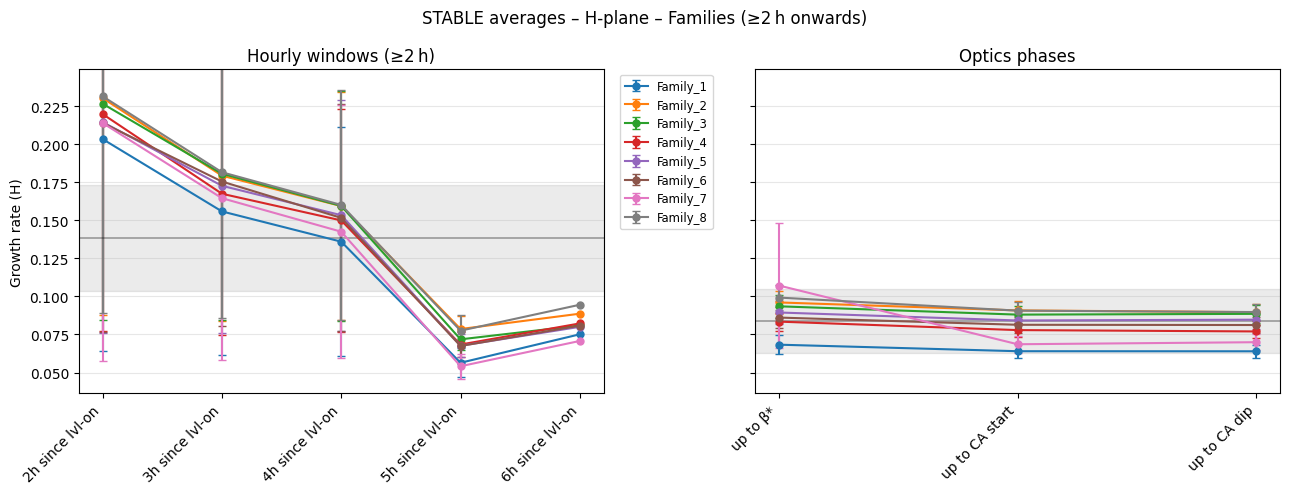


=== IP‑group 15_only  (14 fills) ===


Family_1                                Family_7            \
                        H                   V                   H             
                     mean       sem      mean       sem      mean       sem   
window                                                                        
1h since lvl-on -0.139147  0.197326 -0.127575  0.187022 -0.174045  0.247893   
2h since lvl-on  0.213651  0.136686  0.185952  0.116242  0.232978  0.165542   
3h since lvl-on  0.164175  0.091564  0.151089  0.081068  0.173819  0.112289   
4h since lvl-on  0.144120  0.072830  0.108710  0.036226  0.147882  0.087620   
5h since lvl-on  0.071093  0.011289  0.074450  0.008082  0.063589  0.009751   

                                     
                        V            
                     mean       sem  
window                               
1h since lvl-on -0.201991  0.239409  
2h since lvl-on  0.191658  0.147958  
3h since lvl-on  0.151068  0.102596  
4h since lvl-on  0.131671  0.079530  
5h since lvl-on  0.056056  0.006831

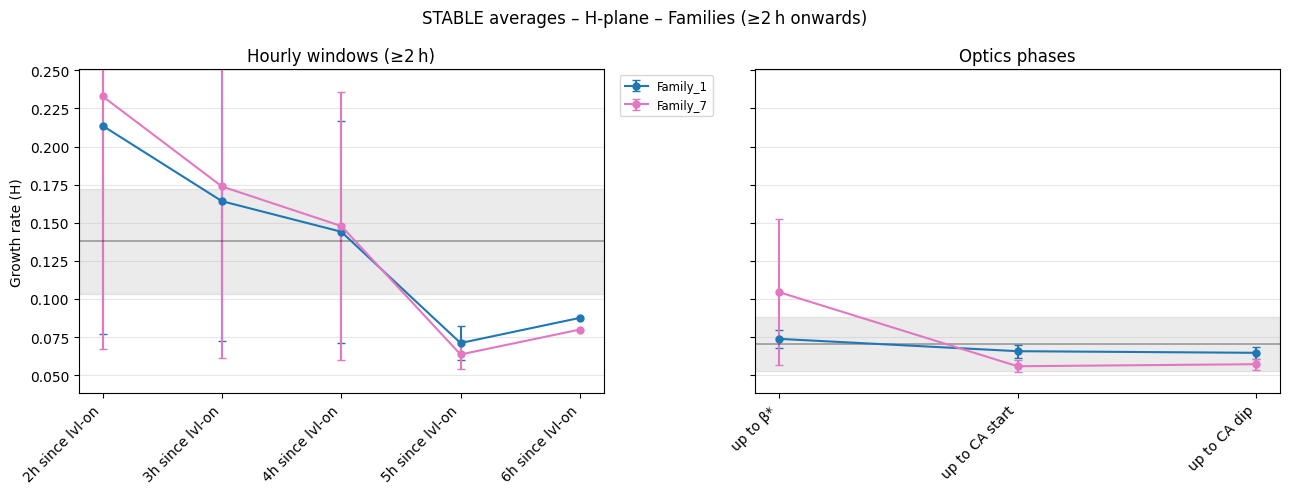

KeyError: ('Family_1', 'H', 'mean')

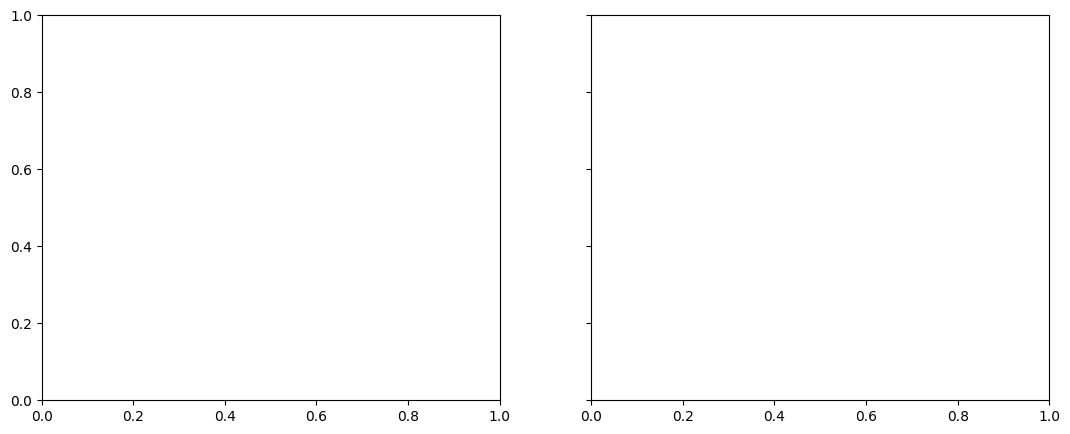

In [ ]:
import re
_IP_COLORS = {          # distinct colours for IP‑groups
    "15_only": "#1f77b4",
    "2_only":  "#ff7f0e",
    "8_only":  "#2ca02c",
    "15_2":    "#d62728",
    "15_8":    "#9467bd",
    "2_8":     "#8c564b",
    "15_2_8":  "#e377c2",
    "none":    "#7f7f7f",
}

def _filter_wins(wins):
    """Drop the first 1‑hour window if present, keep order."""
    return [w for w in wins if not re.match(r"^1h since", w)]

def _family_common_windows(avg_by_ip):
    """Return tuple(hourly, optics) present in *all* IP tables."""
    ipg0 = next(iter(avg_by_ip))
    base = avg_by_ip[ipg0].index
    for ipg, df in avg_by_ip.items():
        base = base.intersection(df.index)
    hourly = _filter_wins([w for w in base if "h since" in w])
    optics = [w for w in ("up to β*", "up to CA start", "up to CA dip") if w in base]
    return hourly, optics

def _tight_ylim_family(avg_by_ip, fam, plane, wins, pad=0.1):
    vals = []
    for df in avg_by_ip.values():
        vals.append(df.loc[wins, (fam, plane, "mean")].to_numpy())
    arr = np.concatenate(vals)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0: return None
    lo, hi = arr.min(), arr.max()
    span = hi - lo if hi > lo else 1.0
    return lo - pad*span, hi + pad*span

def plot_family_across_ips(avg_by_ip: dict[str, pd.DataFrame],
                           family: str,
                           plane: str = "H",
                           group_spacing: float = 1.2,
                           figsize: tuple[int,int] = (13,5)):
    hourly, optics = _family_common_windows(avg_by_ip)
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    ylim = _tight_ylim_family(avg_by_ip, family, plane, hourly+optics)

    for ax, wins, title in zip(axes,
                               [hourly, optics],
                               ["Hourly windows (≥2 h)", "Optics phases"]):
        x0 = np.arange(len(wins)) * group_spacing
        for ipg, df in avg_by_ip.items():
            if (family, plane, "mean") not in df.columns:
                continue
            m = df.loc[wins, (family, plane, "mean")].to_numpy()
            e = df.loc[wins, (family, plane, "sem" )].to_numpy()
            ax.errorbar(x0, m, yerr=e, fmt="-o", capsize=3, ms=5,
                        label=ipg,
                        color=_IP_COLORS.get(ipg, None))
        ax.set_xticks(x0); ax.set_xticklabels(wins, rotation=45, ha="right")
        ax.set_title(title); ax.grid(axis="y", alpha=0.3)
        if ylim: ax.set_ylim(*ylim)

    axes[0].set_ylabel(f"{plane}-plane growth rate")
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
    fig.suptitle(f"Family {family} – {plane}-plane – IP‑group comparison")
    fig.tight_layout()
    plt.show()
avg_by_ip = main()     

In [22]:
import re

_IP_COLORS = {
    "15_only": "#1f77b4", "2_only": "#ff7f0e", "8_only": "#2ca02c",
    "15_2": "#d62728",    "15_8":  "#9467bd",  "2_8":  "#8c564b",
    "15_2_8": "#e377c2",  "none":  "#7f7f7f",
}

def _filter_wins(wins):
    return [w for w in wins if not re.match(r"^1h since", w)]

def _family_common_windows(avg_by_ip):
    ipg0 = next(iter(avg_by_ip))
    base = avg_by_ip[ipg0].index
    for df in avg_by_ip.values():
        base = base.intersection(df.index)
    hourly = _filter_wins([w for w in base if "h since" in w])
    optics = [w for w in ("up to β*", "up to CA start", "up to CA dip") if w in base]
    return hourly, optics

def _tight_ylim_family(avg_by_ip, fam, plane, wins, pad=0.1):
    vals = []
    for df in avg_by_ip.values():
        col = (fam, plane, "mean")
        if col in df.columns:
            vals.append(df.loc[wins, col].to_numpy())
    if not vals:
        return None
    arr = np.concatenate(vals); arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return None
    lo, hi = arr.min(), arr.max()
    span = hi - lo if hi > lo else 1.0
    return lo - pad*span, hi + pad*span

def plot_family_across_ips(avg_by_ip: dict[str, pd.DataFrame],
                           family: str,
                           plane: str = "H",
                           group_spacing: float = 1.2,
                           figsize=(13, 5)):
    hourly, optics = _family_common_windows(avg_by_ip)

    # check the family actually exists somewhere
    exists = any((family, plane, "mean") in df.columns for df in avg_by_ip.values())
    if not exists:
        print(f"[info] Family {family!r} has no {plane}-plane data in any IP‑group.")
        return

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    ylim = _tight_ylim_family(avg_by_ip, family, plane, hourly+optics)

    for ax, wins, title in zip(axes,
                               [hourly, optics],
                               ["Hourly windows (≥2 h)", "Optics phases"]):
        x0 = np.arange(len(wins)) * group_spacing
        for ipg, df in avg_by_ip.items():
            col_mean = (family, plane, "mean")
            col_sem  = (family, plane, "sem")
            if col_mean not in df.columns:           # skip missing family
                continue
            m = df.loc[wins, col_mean].to_numpy()
            e = df.loc[wins, col_sem ].to_numpy()
            ax.errorbar(x0, m, yerr=e, fmt="-o", capsize=3, ms=5,
                        label=ipg, color=_IP_COLORS.get(ipg))
        ax.set_xticks(x0); ax.set_xticklabels(wins, rotation=45, ha="right")
        ax.set_title(title); ax.grid(axis="y", alpha=0.3)
        if ylim: ax.set_ylim(*ylim)

    axes[0].set_ylabel(f"{plane}-plane growth rate")
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
    fig.suptitle(f"Family {family} – {plane}-plane – IP‑group comparison")
    fig.tight_layout(); plt.show()

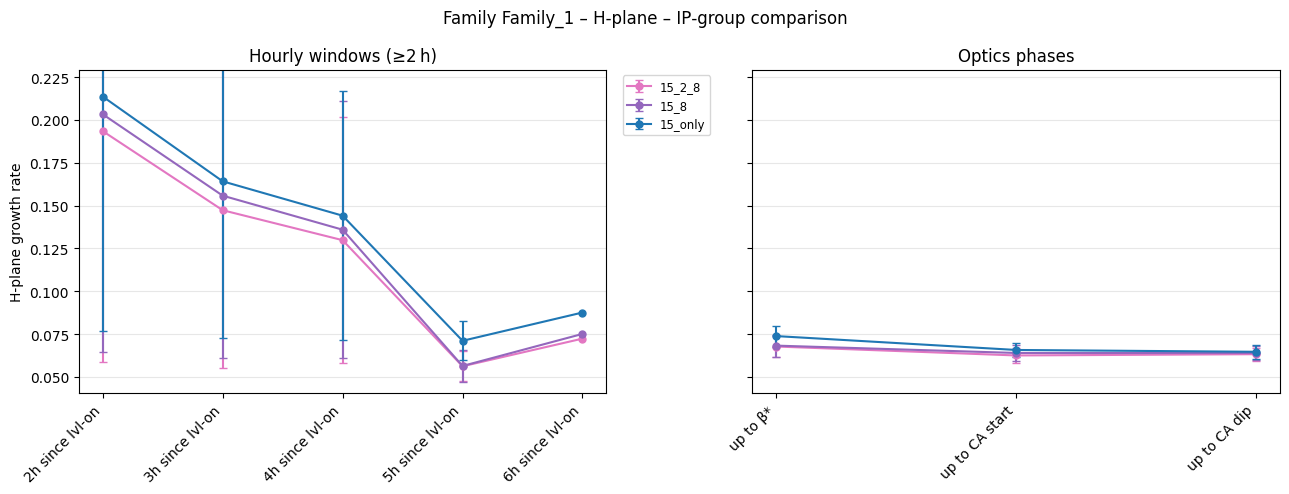

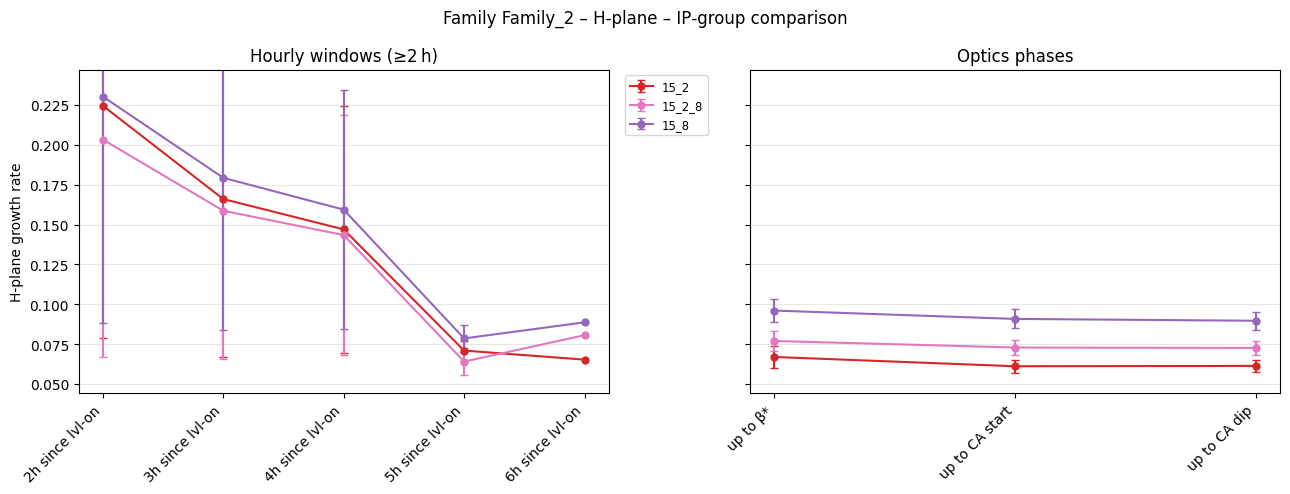

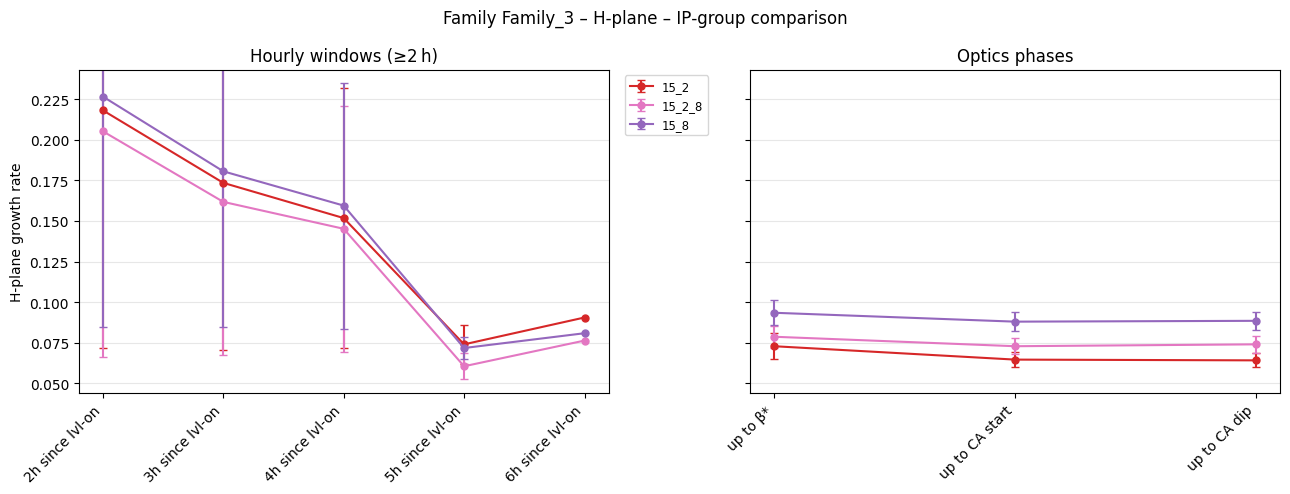

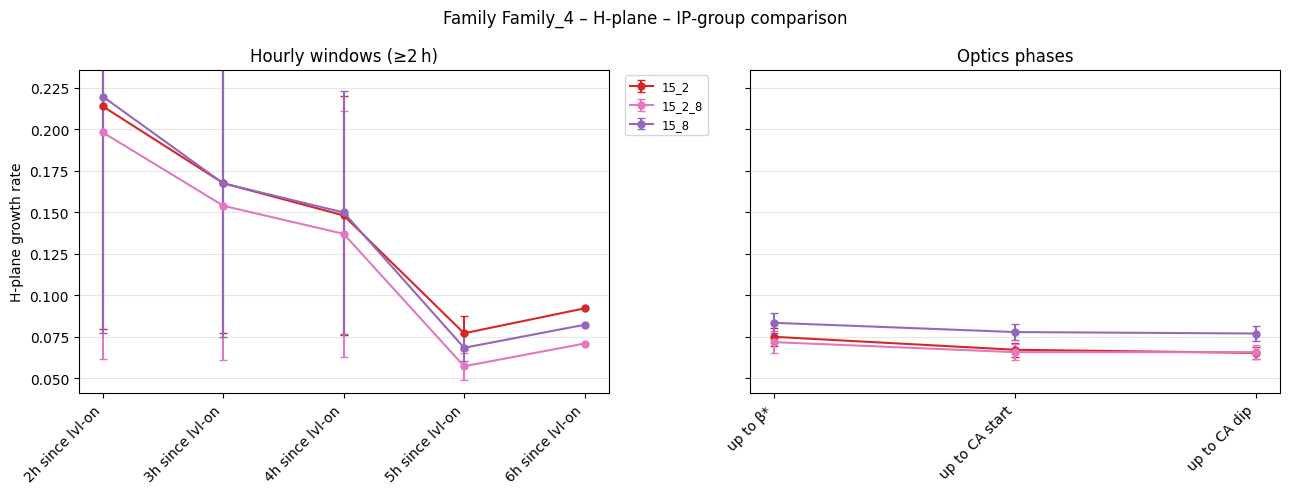

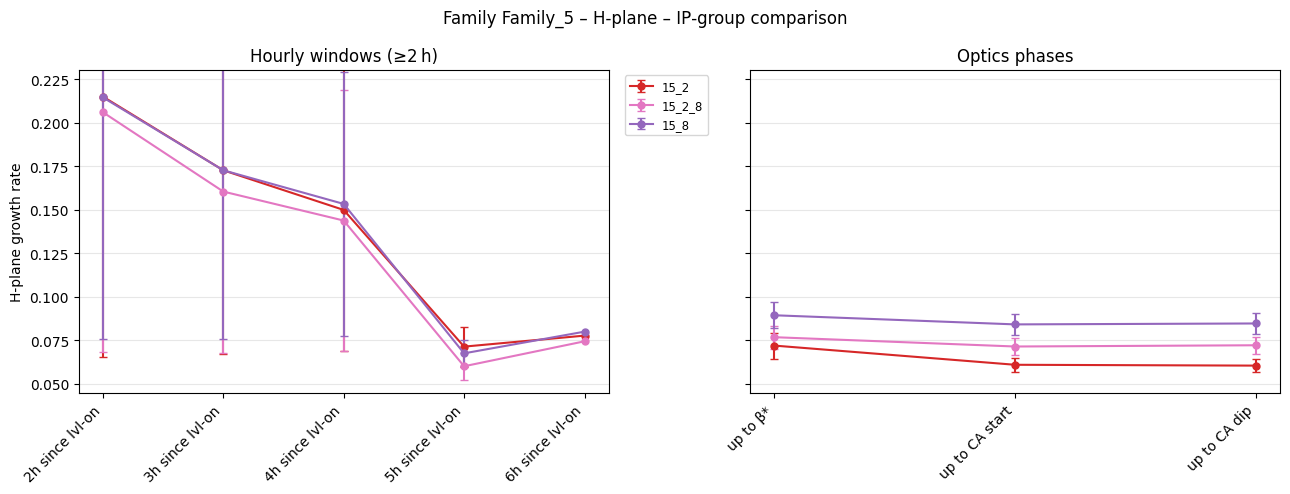

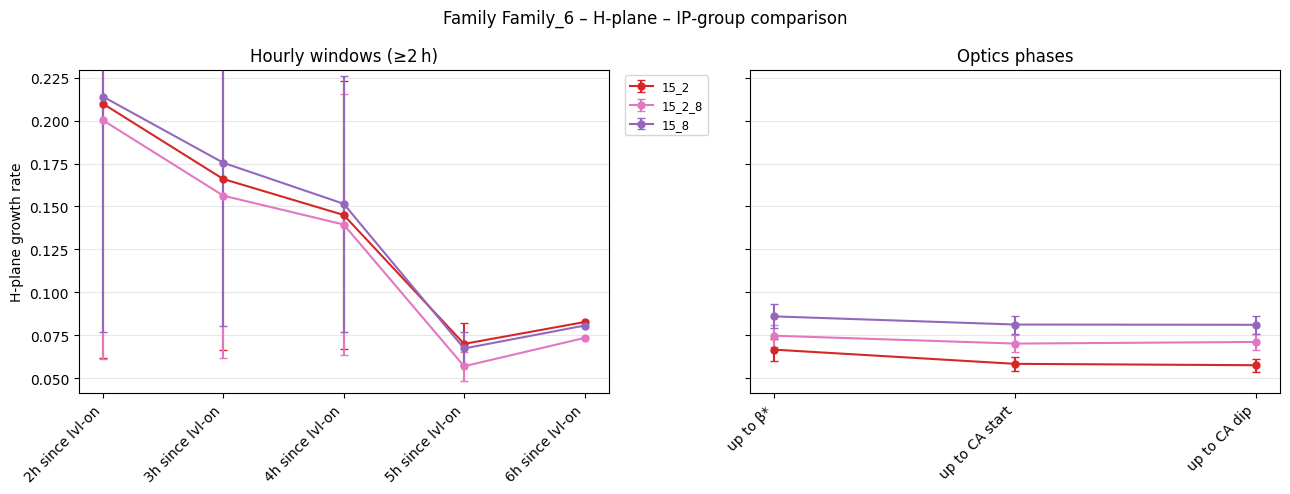

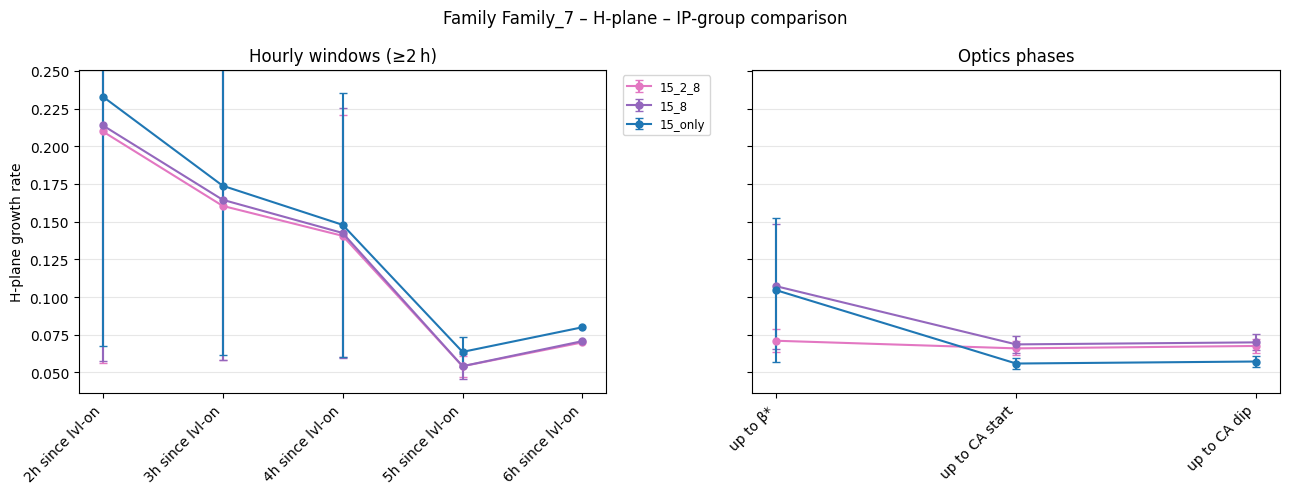

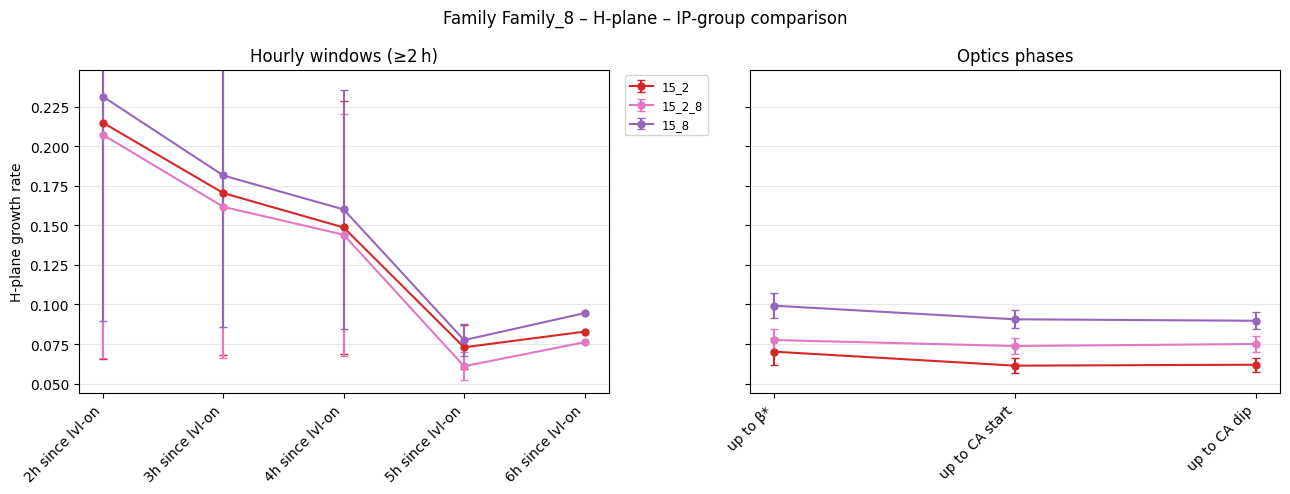

In [23]:
                # run analysis, capture output
for fam in ["Family_1","Family_2","Family_3","Family_4","Family_5","Family_6","Family_7","Family_8"]:
     plot_family_across_ips(avg_by_ip, fam, plane="H")


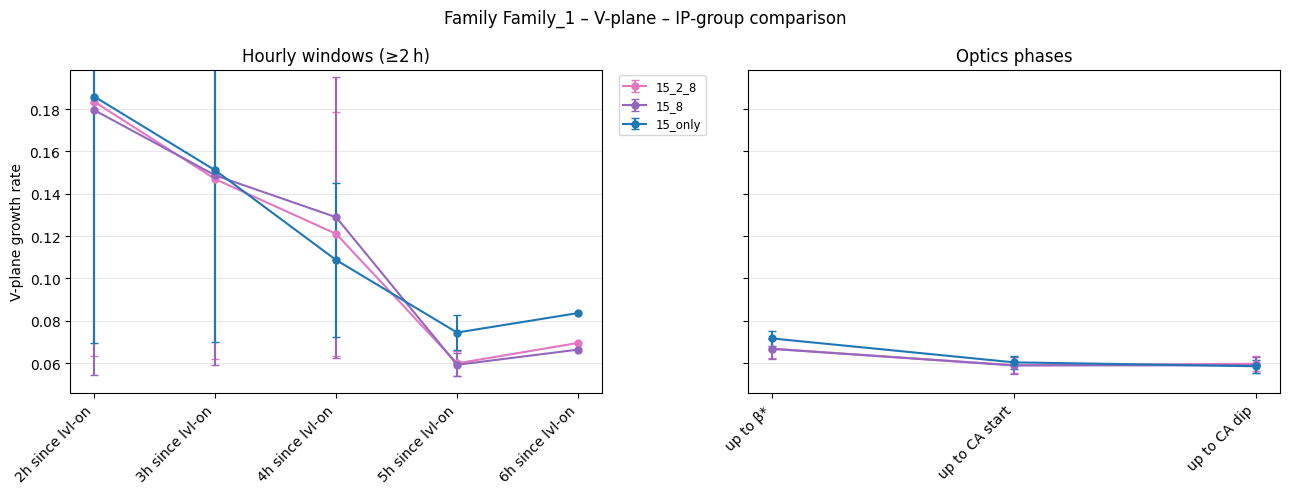

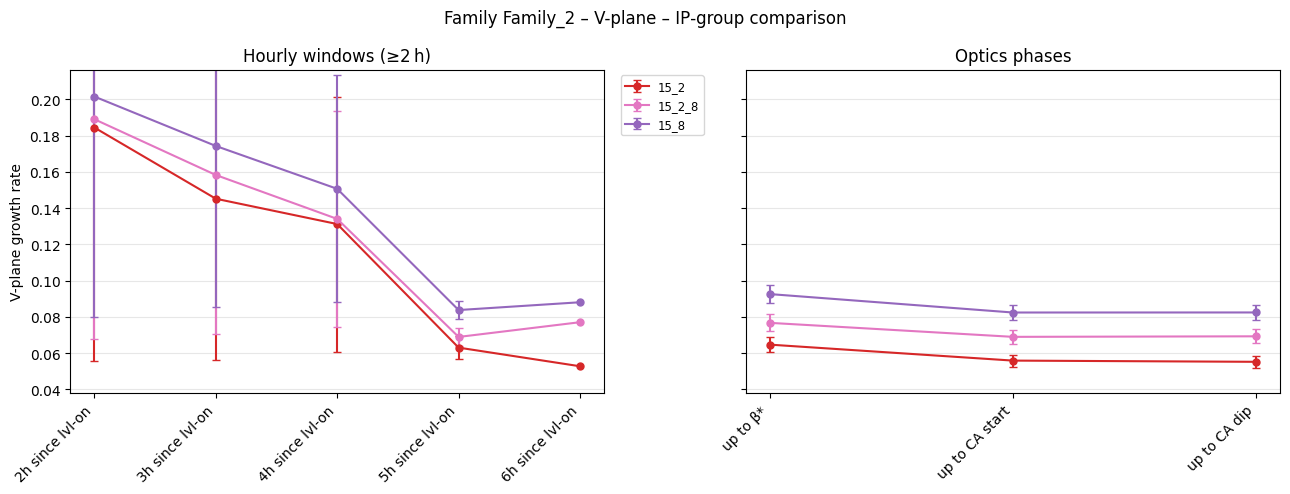

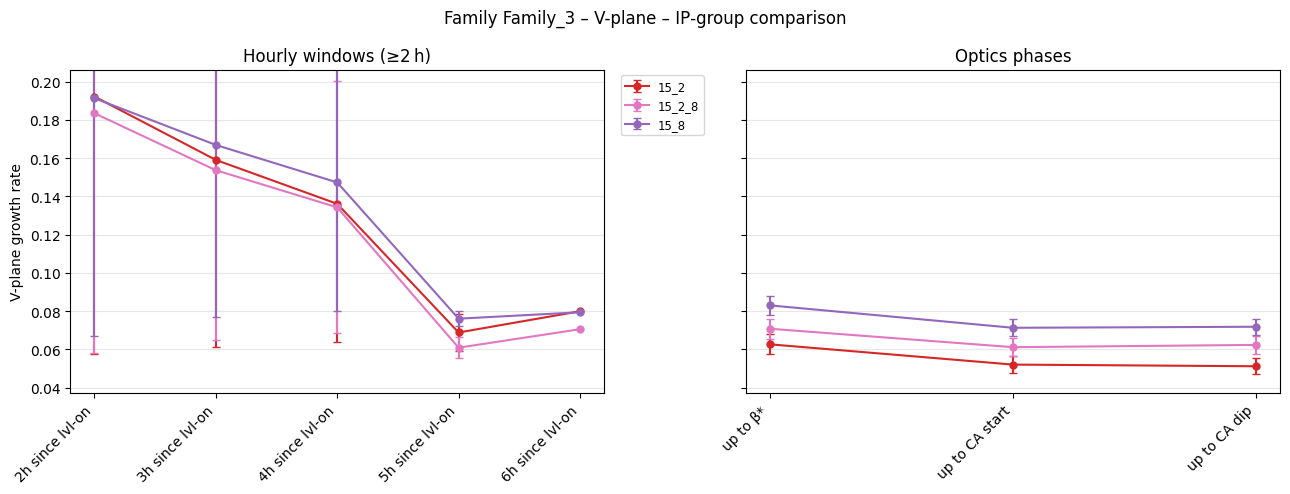

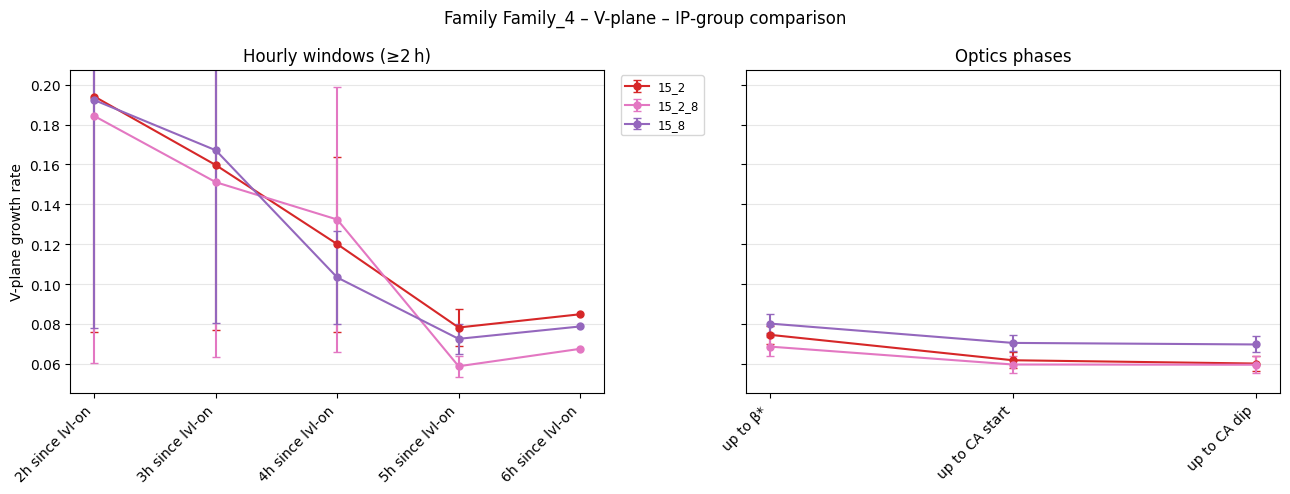

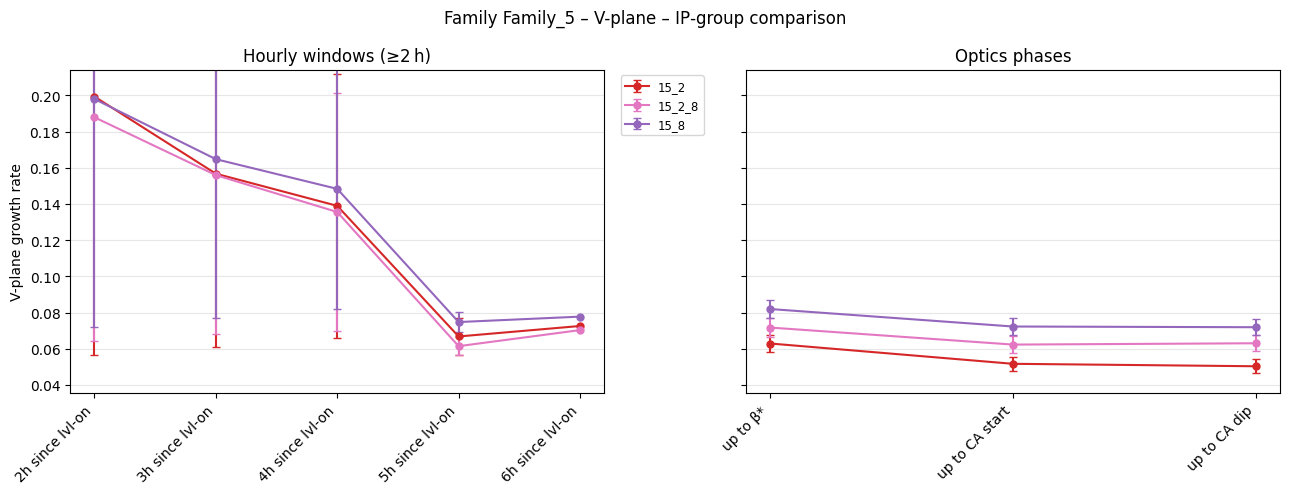

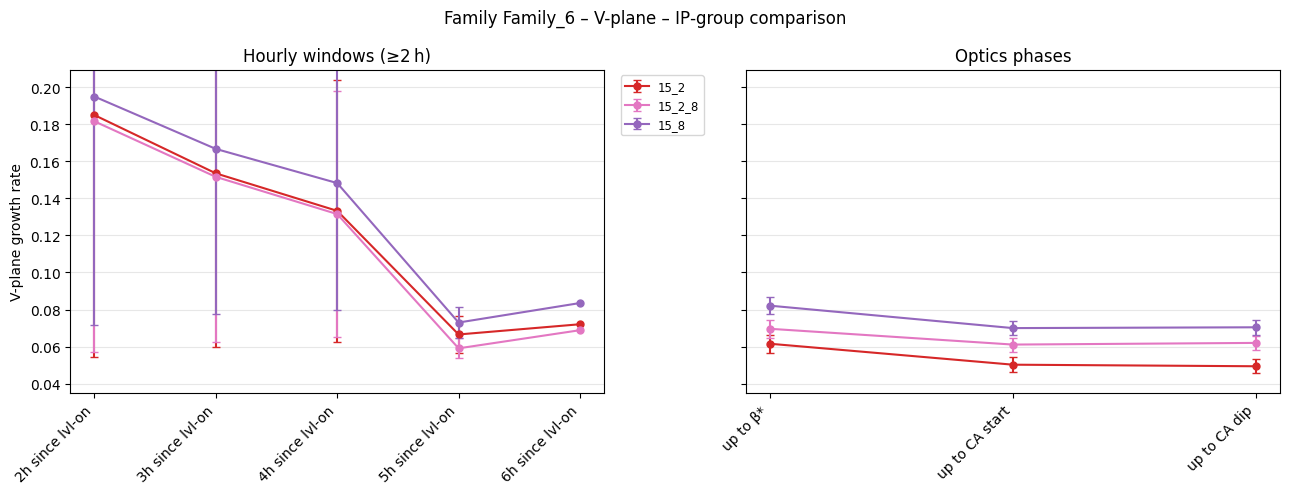

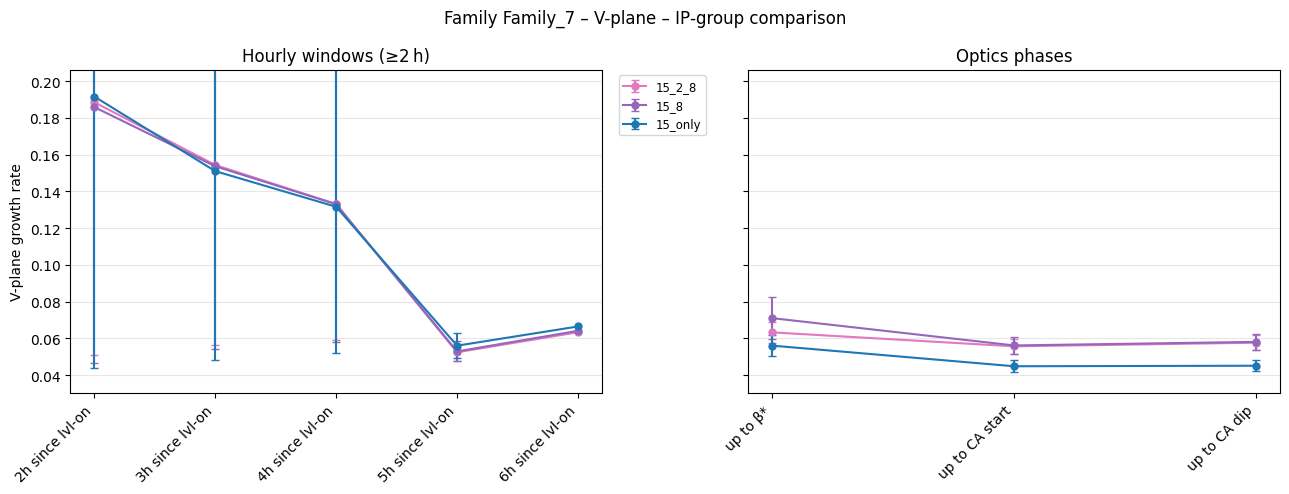

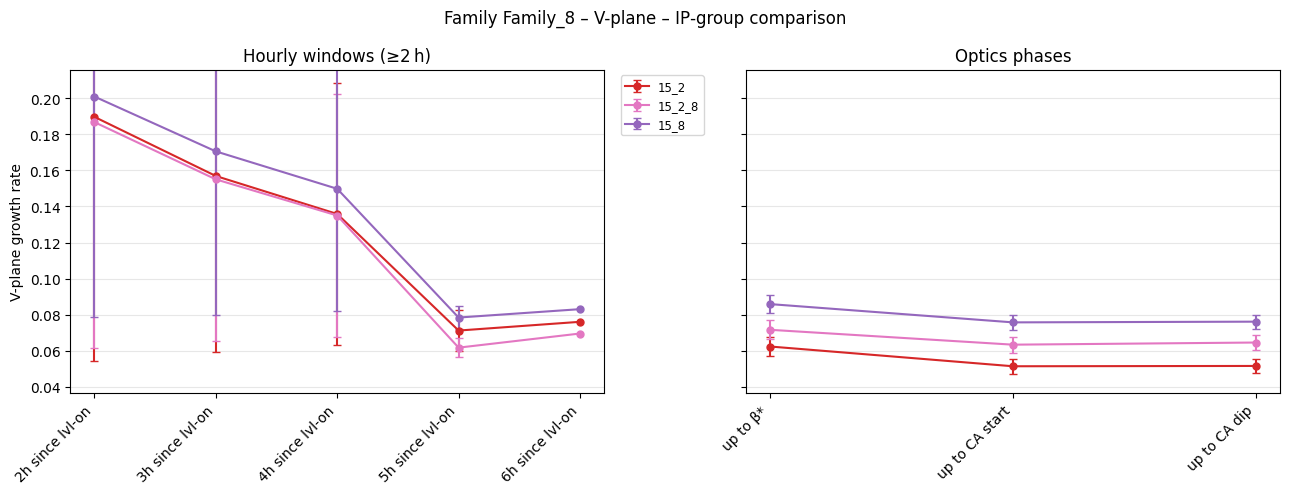

In [24]:
for fam in ["Family_1","Family_2","Family_3","Family_4","Family_5","Family_6","Family_7","Family_8"]:
     plot_family_across_ips(avg_by_ip, fam, plane="V")